# GEMINI

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import time
from tqdm import tqdm
import pandas as pd
import math # For Positional Encoding

# --- Configuration ---
# Data Generation Parameters
N_SAMPLES_TOTAL = 50000
N_TEST_SAMPLES = 500
T_LENGTH = 2000
VAL_SPLIT_RATIO = 0.1

# SVJD Model Parameter Ranges
MU_RANGE = (-0.1 / 250, 0.1 / 250)
V_LT_RANGE = (0.005**2, 0.015**2) 
BETA_RANGE = (0.79, 0.99)
GAMMA_RANGE = (0.05, 0.50)
MU_J_RANGE = (-0.05, 0.05)
SIGMA_J_RANGE = (0.01, 0.10)
LAMBDA_RANGE = (0.005, 0.05)

PARAM_NAMES = ["mju", "mjuJ", "sigmaJ", "varLT", "beta", "gamma", "lambda"]
NUM_RESPONSES = 7

# --- LSTM-Transformer Architecture Parameters ---
INPUT_FEATURE_DIM = 1 # Number of features per time step (e.g., 1 for raw returns)

# LSTM Part
LSTM_HIDDEN_SIZE = 64
LSTM_NUM_LAYERS = 2
LSTM_BIDIRECTIONAL = True
LSTM_DROPOUT = 0.1 # Dropout between LSTM layers if num_layers > 1

# Dimension of LSTM output features fed to Transformer's input projection
LSTM_OUTPUT_FEATURE_DIM = LSTM_HIDDEN_SIZE * (2 if LSTM_BIDIRECTIONAL else 1)

# Transformer Part
TRANSFORMER_D_MODEL = 64  # Embedding dimension for the Transformer
TRANSFORMER_NHEAD = 4     # Number of attention heads (d_model must be divisible by nhead)
TRANSFORMER_NUM_ENCODER_LAYERS = 2 # Reduced slightly due to LSTM frontend
TRANSFORMER_DIM_FEEDFORWARD = 128 
TRANSFORMER_DROPOUT = 0.1
PE_DROPOUT = 0.1          # Dropout for positional encoding

# Final MLP Part (after Transformer)
MLP_NUM_NEURONS_FC = 64 

# Training Parameters
BATCH_SIZE = 16 # Potentially small due to model size
MAX_EPOCHS = 100      
LEARNING_RATE = 1e-4 
EARLY_STOPPING_PATIENCE = 20
LEAKY_RELU_SLOPE = 0.01

# Seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. SVJD Data Generation (Vectorized) ---
def generate_svjd_data(n_samples, t_length, fixed_params=None):
    if fixed_params is not None:
        action_desc = "Generating SVJD Data (Fixed Params)"
        mu_val_arr = np.full(n_samples, fixed_params[0])
        mu_j_val_arr = np.full(n_samples, fixed_params[1])
        sigma_j_val_arr = np.full(n_samples, fixed_params[2])
        v_lt_val_arr = np.full(n_samples, fixed_params[3])
        beta_val_arr = np.full(n_samples, fixed_params[4])
        gamma_val_arr = np.full(n_samples, fixed_params[5])
        lambda_val_arr = np.full(n_samples, fixed_params[6])
    else:
        action_desc = "Generating SVJD Data (Sampled Params)"
        mu_val_arr = np.random.uniform(*MU_RANGE, size=n_samples)
        v_lt_base_arr = np.random.uniform(np.sqrt(V_LT_RANGE[0]), np.sqrt(V_LT_RANGE[1]), size=n_samples)
        v_lt_val_arr = v_lt_base_arr**2
        beta_val_arr = np.random.uniform(*BETA_RANGE, size=n_samples)
        gamma_val_arr = np.random.uniform(*GAMMA_RANGE, size=n_samples)
        mu_j_val_arr = np.random.uniform(*MU_J_RANGE, size=n_samples)
        sigma_j_val_arr = np.random.uniform(*SIGMA_J_RANGE, size=n_samples)
        lambda_val_arr = np.random.uniform(*LAMBDA_RANGE, size=n_samples)

    all_params_np = np.column_stack((mu_val_arr, mu_j_val_arr, sigma_j_val_arr, 
                                     v_lt_val_arr, beta_val_arr, gamma_val_arr, lambda_val_arr))
    alpha_val_arr = np.log(v_lt_val_arr) * (1 - beta_val_arr)
    eps_h_all = np.random.normal(0, 1, size=(n_samples, t_length))
    eps_r_all = np.random.normal(0, 1, size=(n_samples, t_length))
    Z_all = np.random.binomial(1, lambda_val_arr[:, np.newaxis], size=(n_samples, t_length))
    J_components_all = np.random.normal(mu_j_val_arr[:, np.newaxis], 
                                        sigma_j_val_arr[:, np.newaxis], 
                                        size=(n_samples, t_length))
    J_all = J_components_all * Z_all
    h_all = np.zeros((n_samples, t_length))
    h_all[:, 0] = np.log(v_lt_val_arr)

    use_tqdm_ht = n_samples > 100 or fixed_params is None 
    ht_iterator = tqdm(range(t_length - 1), desc="Simulating h_t paths", leave=False) if use_tqdm_ht else range(t_length - 1)

    for t_idx in ht_iterator:
        h_all[:, t_idx + 1] = alpha_val_arr + beta_val_arr * h_all[:, t_idx] + gamma_val_arr * eps_h_all[:, t_idx]

    sigma_t_sq_all = np.exp(h_all)
    sigma_t_all = np.sqrt(sigma_t_sq_all)
    returns_all_np = mu_val_arr[:, np.newaxis] + sigma_t_all * eps_r_all + J_all
    return torch.tensor(returns_all_np, dtype=torch.float32), torch.tensor(all_params_np, dtype=torch.float32)

# --- 2. Data Preprocessing ---
def normalize_inputs(data_tensor, mean_val=None, std_val=None):
    if mean_val is None or std_val is None: 
        mean_val = torch.mean(data_tensor) 
        std_val = torch.std(data_tensor)
        if std_val == 0: std_val = 1.0
    return (data_tensor - mean_val) / std_val, mean_val, std_val

def normalize_outputs(data_tensor, mean_vals=None, std_vals=None):
    if mean_vals is None or std_vals is None: 
        mean_vals = torch.mean(data_tensor, dim=0) 
        std_vals = torch.std(data_tensor, dim=0)
        std_vals[std_vals == 0] = 1.0 
    return (data_tensor - mean_vals) / std_vals, mean_vals, std_vals

def denormalize_outputs(normalized_data_tensor, mean_vals, std_vals):
    return normalized_data_tensor * std_vals + mean_vals

# --- 3. LSTM-Transformer Model Definition ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 != 0: 
             pe[:, 1::2] = torch.cos(position * div_term[:-1]) 
        else:
             pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:x.size(1), :] 
        return self.dropout(x)

class LSTMTransformerSVJD(nn.Module):
    def __init__(self, num_input_features=INPUT_FEATURE_DIM, num_responses=NUM_RESPONSES,
                 lstm_hidden_size=LSTM_HIDDEN_SIZE,
                 lstm_num_layers=LSTM_NUM_LAYERS,
                 lstm_bidirectional=LSTM_BIDIRECTIONAL,
                 lstm_dropout=LSTM_DROPOUT,
                 transformer_d_model=TRANSFORMER_D_MODEL,
                 transformer_nhead=TRANSFORMER_NHEAD,
                 transformer_num_encoder_layers=TRANSFORMER_NUM_ENCODER_LAYERS,
                 transformer_dim_feedforward=TRANSFORMER_DIM_FEEDFORWARD,
                 transformer_dropout=TRANSFORMER_DROPOUT,
                 pe_dropout=PE_DROPOUT,
                 mlp_fc_neurons=MLP_NUM_NEURONS_FC,
                 leaky_slope=LEAKY_RELU_SLOPE,
                 max_seq_len_for_pe=T_LENGTH
                 ):
        super(LSTMTransformerSVJD, self).__init__()
        
        self.lstm_output_dim = lstm_hidden_size * (2 if lstm_bidirectional else 1)

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=num_input_features,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            bidirectional=lstm_bidirectional,
            dropout=lstm_dropout if lstm_num_layers > 1 else 0, # Dropout only between layers
            batch_first=True # Input: (batch, seq, feature)
        )
        
        # Linear layer to project LSTM output to Transformer's d_model
        self.lstm_to_transformer_projection = nn.Linear(self.lstm_output_dim, transformer_d_model)
        
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(transformer_d_model, pe_dropout, max_len=max_seq_len_for_pe)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_d_model, 
            nhead=transformer_nhead,
            dim_feedforward=transformer_dim_feedforward,
            dropout=transformer_dropout,
            batch_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=transformer_num_encoder_layers)

        # Final MLP
        self.fc1_mlp = nn.Linear(transformer_d_model, mlp_fc_neurons)
        self.relu_fc1_mlp = nn.LeakyReLU(leaky_slope)
        self.ln_fc1_mlp = nn.LayerNorm(mlp_fc_neurons)
        
        self.fc2_mlp = nn.Linear(mlp_fc_neurons, mlp_fc_neurons // 2)
        self.relu_fc2_mlp = nn.LeakyReLU(leaky_slope)
        self.ln_fc2_mlp = nn.LayerNorm(mlp_fc_neurons // 2)

        self.fc_out_mlp = nn.Linear(mlp_fc_neurons // 2, num_responses)

    def forward(self, x):
        # x shape: (batch_size, num_input_features, sequence_length)
        # e.g., (batch_size, 1, 2000)
        if x.ndim == 2: # (batch_size, sequence_length) -> assumes num_input_features=1
            x = x.unsqueeze(1) # Add feature dimension

        x = x.permute(0, 2, 1) # (batch_size, sequence_length, num_input_features) for LSTM
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, lstm_output_dim)
        
        # Project LSTM output to Transformer d_model
        transformer_input = self.lstm_to_transformer_projection(lstm_out)
        # transformer_input shape: (batch_size, sequence_length, transformer_d_model)
        
        transformer_input = self.pos_encoder(transformer_input)
        
        # Transformer Encoder
        transformer_out = self.transformer_encoder(transformer_input)
        # transformer_out shape: (batch_size, sequence_length, transformer_d_model)
        
        # Aggregate Transformer output - e.g., mean pooling over sequence dimension
        aggregated_out = transformer_out.mean(dim=1) # (batch_size, transformer_d_model)
        
        # Final MLP
        mlp_out = self.fc1_mlp(aggregated_out); mlp_out = self.relu_fc1_mlp(mlp_out); mlp_out = self.ln_fc1_mlp(mlp_out)
        mlp_out = self.fc2_mlp(mlp_out); mlp_out = self.relu_fc2_mlp(mlp_out); mlp_out = self.ln_fc2_mlp(mlp_out)
        final_out = self.fc_out_mlp(mlp_out)
        
        return final_out

# --- 4. R-squared Calculation ---
def calculate_r2_score(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_tot = torch.sum((y_true - torch.mean(y_true, dim=0))**2, dim=0)
    return 1 - ss_res / (ss_tot + 1e-8) 

# --- 5. Training Loop ---
def train_model(model, train_loader, val_loader, test_loader_norm, test_params_raw,
                criterion, optimizer, num_epochs, patience, device,
                param_output_means, param_output_stds, param_names_list):
    print(f"Starting training with model: {model.__class__.__name__}")
    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'test_r2': {name: [] for name in param_names_list}}
    model_save_path = f'best_svjd_{model.__class__.__name__.lower()}_model.pth'

    for epoch in range(num_epochs):
        start_time_epoch = time.time()
        model.train()
        running_train_loss = 0.0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        if val_loader:
            with torch.no_grad():
                for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    running_val_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            history['val_loss'].append(epoch_val_loss)
        else:
            epoch_val_loss = float('nan') 
            history['val_loss'].append(epoch_val_loss)
        
        all_test_preds_denorm = []
        r2_scores_dict = {name: float('nan') for name in param_names_list} 
        if test_loader_norm and test_params_raw is not None:
            with torch.no_grad():
                for test_inputs_batch in tqdm(test_loader_norm, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False):
                    test_inputs_batch = test_inputs_batch[0].to(device) 
                    preds_norm = model(test_inputs_batch)
                    preds_denorm = denormalize_outputs(preds_norm.cpu(), param_output_means, param_output_stds)
                    all_test_preds_denorm.append(preds_denorm)
            
            if all_test_preds_denorm:
                all_test_preds_denorm_tensor = torch.cat(all_test_preds_denorm, dim=0)
                r2_scores_test = calculate_r2_score(test_params_raw.cpu(), all_test_preds_denorm_tensor)
                r2_scores_dict = {name: r2_scores_test[i].item() for i, name in enumerate(param_names_list)}
                for name, r2_val in r2_scores_dict.items():
                    history['test_r2'][name].append(r2_val)

        end_time_epoch = time.time()
        epoch_duration = end_time_epoch - start_time_epoch
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}, Duration: {epoch_duration:.2f}s")
        if test_loader_norm and all_test_preds_denorm: 
            r2_report_str = ", ".join([f"R2({name}): {score:.4f}" for name, score in r2_scores_dict.items()])
            print(f"Test R2 Scores: {r2_report_str}")

        if val_loader and epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path) 
        elif val_loader:
            epochs_no_improve += 1

        if val_loader and epochs_no_improve >= patience: 
            print(f"Early stopping triggered after {patience} epochs without improvement on validation set.")
            break
            
    print("Training finished.")
    if val_loader and best_val_loss != float('inf'): 
        print(f"Loading best model weights from {model_save_path} based on validation loss...")
        try:
            model.load_state_dict(torch.load(model_save_path))
        except FileNotFoundError:
            print(f"Warning: '{model_save_path}' not found. Using last model state.")
    elif not val_loader:
        print("No validation loader provided, using last model state.")
    else: 
        print("Best validation loss was not updated, using last model state.")
        
    return model, history

# --- 6. Evaluation Function for Fixed Parameters ---
def evaluate_model_on_fixed_params(trained_model, fixed_params_vector, N_eval_samples, t_length, 
                                   returns_norm_mean_stat, returns_norm_std_stat, 
                                   params_norm_means_stat, params_norm_stds_stat, 
                                   device, param_names_list):
    print(f"\n--- Evaluating model {trained_model.__class__.__name__} on {N_eval_samples} samples with fixed parameters ---")
    if isinstance(fixed_params_vector, torch.Tensor):
        fixed_params_vector = fixed_params_vector.cpu().numpy().tolist()
    elif isinstance(fixed_params_vector, np.ndarray):
        fixed_params_vector = fixed_params_vector.tolist()

    eval_returns_raw, eval_params_true_raw = generate_svjd_data(
        n_samples=N_eval_samples, t_length=t_length, fixed_params=fixed_params_vector
    )
    eval_returns_norm, _, _ = normalize_inputs(eval_returns_raw, 
                                               returns_norm_mean_stat, returns_norm_std_stat)
    trained_model.eval()
    all_predictions_denormalized = []
    eval_dataset_norm_inputs_only = TensorDataset(eval_returns_norm)
    eval_loader_norm = DataLoader(eval_dataset_norm_inputs_only, batch_size=BATCH_SIZE, shuffle=False)

    with torch.no_grad():
        for inputs_batch in tqdm(eval_loader_norm, desc="Predicting on fixed-param samples"):
            inputs_batch = inputs_batch[0].to(device)
            predicted_params_norm = trained_model(inputs_batch)
            predicted_params_denorm = denormalize_outputs(
                predicted_params_norm.cpu(), params_norm_means_stat, params_norm_stds_stat
            )
            all_predictions_denormalized.append(predicted_params_denorm)
    if not all_predictions_denormalized: return pd.DataFrame()
    all_predictions_tensor = torch.cat(all_predictions_denormalized, dim=0)
    df_data = {}
    for i, name in enumerate(param_names_list):
        df_data[f'{name}_true'] = eval_params_true_raw[:, i].cpu().numpy()
        df_data[f'{name}_pred'] = all_predictions_tensor[:, i].cpu().numpy()
    results_df = pd.DataFrame(df_data)
    print(f"--- Evaluation with fixed parameters complete. ---")
    return results_df

# --- 7. Test Parameter Range Function ---
def test_parameter_range(trained_model, param_to_test_name, param_min_val, param_max_val, num_steps,
                         base_params_dict, N_series_per_step, t_length,
                         returns_norm_mean_stat, returns_norm_std_stat,
                         params_norm_means_stat, params_norm_stds_stat,
                         device, all_param_names_list):
    print(f"\n--- Testing {trained_model.__class__.__name__} for '{param_to_test_name}' from {param_min_val:.4f} to {param_max_val:.4f} ---")
    param_values_to_test = np.linspace(param_min_val, param_max_val, num_steps)
    results_list = []
    try:
        param_idx_to_test = all_param_names_list.index(param_to_test_name)
    except ValueError: return pd.DataFrame() 
    base_full_params_ordered = [base_params_dict.get(name, 0.0) for name in all_param_names_list]

    for test_val in tqdm(param_values_to_test, desc=f"Testing range for {param_to_test_name}"):
        current_full_params = list(base_full_params_ordered)
        current_full_params[param_idx_to_test] = test_val
        series_batch_raw, _ = generate_svjd_data(
            n_samples=N_series_per_step, t_length=t_length, fixed_params=current_full_params
        )
        series_batch_norm, _, _ = normalize_inputs(series_batch_raw, returns_norm_mean_stat, returns_norm_std_stat)
        trained_model.eval()
        batch_predictions_denorm_list = []
        temp_dataset = TensorDataset(series_batch_norm)
        temp_loader = DataLoader(temp_dataset, batch_size=BATCH_SIZE, shuffle=False)
        with torch.no_grad():
            for inputs_batch_eval in temp_loader:
                inputs_eval = inputs_batch_eval[0].to(device)
                preds_norm_eval = trained_model(inputs_eval)
                preds_denorm_eval = denormalize_outputs(preds_norm_eval.cpu(), params_norm_means_stat, params_norm_stds_stat)
                batch_predictions_denorm_list.append(preds_denorm_eval)
        if not batch_predictions_denorm_list: continue
        batch_predictions_denorm = torch.cat(batch_predictions_denorm_list, dim=0)
        avg_prediction_for_step = torch.mean(batch_predictions_denorm, dim=0).numpy()
        row_data = {f'{param_to_test_name}_true': test_val}
        for i, name in enumerate(all_param_names_list):
            row_data[f'{name}_pred'] = avg_prediction_for_step[i]
        results_list.append(row_data)
    if not results_list: return pd.DataFrame()
    results_df = pd.DataFrame(results_list)
    print(f"--- Parameter range testing for '{param_to_test_name}' complete. ---")
    return results_df

# --- 8. Main Script Execution ---
if __name__ == '__main__':
    # Quick test settings
    # actual_n_train_val = 1000 
    # actual_n_test = 50       
    # actual_max_epochs = 3 
    # N_for_fixed_eval = 5
    # num_sweep_steps = 5
    # current_batch_size = BATCH_SIZE 

    # Full run settings
    actual_n_train_val = N_SAMPLES_TOTAL
    actual_n_test = N_TEST_SAMPLES
    actual_max_epochs = MAX_EPOCHS
    N_for_fixed_eval = 100 
    num_sweep_steps = 10   
    current_batch_size = BATCH_SIZE


    print(f"--- Generating Training/Validation Data ({actual_n_train_val} samples) ---")
    train_val_returns_raw, train_val_params_raw = generate_svjd_data(actual_n_train_val, T_LENGTH)
    print(f"\n--- Generating Test Data ({actual_n_test} samples) ---")
    test_returns_raw, test_params_raw = generate_svjd_data(actual_n_test, T_LENGTH)

    n_val_samples = int(actual_n_train_val * VAL_SPLIT_RATIO)
    n_train_samples = actual_n_train_val - n_val_samples
    train_val_dataset = TensorDataset(train_val_returns_raw, train_val_params_raw)
    train_dataset_raw_split, val_dataset_raw_split = random_split(train_val_dataset, [n_train_samples, n_val_samples])
    train_returns_for_norm_stats = torch.stack([train_dataset_raw_split[i][0] for i in range(len(train_dataset_raw_split))])
    train_params_for_norm_stats = torch.stack([train_dataset_raw_split[i][1] for i in range(len(train_dataset_raw_split))])

    print("\n--- Normalizing Data (using training split statistics) ---")
    train_returns_norm, returns_mean_stat, returns_std_stat = normalize_inputs(train_returns_for_norm_stats)
    train_params_norm, params_means_stat, params_stds_stat = normalize_outputs(train_params_for_norm_stats)
    print(f"Return series mean: {returns_mean_stat.item():.6f}, std: {returns_std_stat.item():.6f}")
    print(f"Parameter means: {[f'{m:.4f}' for m in params_means_stat.tolist()]}")
    print(f"Parameter stds: {[f'{s:.4f}' for s in params_stds_stat.tolist()]}")

    val_loader = None
    if len(val_dataset_raw_split) > 0:
        val_returns_list_raw = [val_dataset_raw_split[i][0] for i in range(len(val_dataset_raw_split))]
        val_params_list_raw = [val_dataset_raw_split[i][1] for i in range(len(val_dataset_raw_split))]
        val_returns_tensor_raw = torch.stack(val_returns_list_raw)
        val_params_tensor_raw = torch.stack(val_params_list_raw)
        val_returns_norm, _, _ = normalize_inputs(val_returns_tensor_raw, returns_mean_stat, returns_std_stat)
        val_params_norm, _, _ = normalize_outputs(val_params_tensor_raw, params_means_stat, params_stds_stat)
        val_dataset_norm = TensorDataset(val_returns_norm, val_params_norm)
        val_loader = DataLoader(val_dataset_norm, batch_size=current_batch_size, shuffle=False)

    test_returns_norm, _, _ = normalize_inputs(test_returns_raw, returns_mean_stat, returns_std_stat)
    train_dataset_norm = TensorDataset(train_returns_norm, train_params_norm)
    train_loader = DataLoader(train_dataset_norm, batch_size=current_batch_size, shuffle=True)
    test_dataset_norm_inputs_only = TensorDataset(test_returns_norm) 
    test_loader_norm = DataLoader(test_dataset_norm_inputs_only, batch_size=current_batch_size, shuffle=False)
    
    print(f"\nTrain loader: {len(train_loader.dataset)} samples. Val loader: {len(val_loader.dataset) if val_loader else 0}. Test loader: {len(test_loader_norm.dataset)}.")

    # Instantiate the NEW LSTM-Transformer model
    lstm_transformer_model = LSTMTransformerSVJD(
        num_input_features=INPUT_FEATURE_DIM, 
        num_responses=NUM_RESPONSES,
        max_seq_len_for_pe= T_LENGTH + 10 
    ).to(DEVICE)
    
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(lstm_transformer_model.parameters(), lr=LEARNING_RATE) 

    trained_model, history = train_model(lstm_transformer_model, train_loader, val_loader, test_loader_norm, test_params_raw,
                                         criterion, optimizer, actual_max_epochs, EARLY_STOPPING_PATIENCE, DEVICE,
                                         params_means_stat, params_stds_stat, PARAM_NAMES)
    
    print(f"\n--- Final R2 Scores on Test Set ({trained_model.__class__.__name__}) ---")
    all_test_preds_denorm_final = []
    trained_model.eval() 
    with torch.no_grad():
        for inputs_final_test_batch in tqdm(test_loader_norm, desc="Final Test Evaluation", leave=False):
            inputs_final_test = inputs_final_test_batch[0].to(DEVICE)
            preds_norm_final = trained_model(inputs_final_test)
            preds_denorm_final = denormalize_outputs(preds_norm_final.cpu(), params_means_stat, params_stds_stat)
            all_test_preds_denorm_final.append(preds_denorm_final)
    if all_test_preds_denorm_final:
        all_test_preds_denorm_tensor_final = torch.cat(all_test_preds_denorm_final, dim=0)
        final_r2_scores_test = calculate_r2_score(test_params_raw.cpu(), all_test_preds_denorm_tensor_final)
        final_r2_scores_dict = {name: final_r2_scores_test[i].item() for i, name in enumerate(PARAM_NAMES)}
        final_r2_report_str = ", ".join([f"R2({name}): {score:.4f}" for name, score in final_r2_scores_dict.items()])
        print(final_r2_report_str)

    example_fixed_params_list = [0.0001, 0.01, 0.05, 0.0002, 0.95, 0.2, 0.02]
    if 'trained_model' in locals() and 'returns_mean_stat' in locals():
        fixed_param_eval_df = evaluate_model_on_fixed_params(
            trained_model=trained_model, fixed_params_vector=example_fixed_params_list,
            N_eval_samples=N_for_fixed_eval, t_length=T_LENGTH,
            returns_norm_mean_stat=returns_mean_stat, returns_norm_std_stat=returns_std_stat,
            params_norm_means_stat=params_means_stat, params_norm_stds_stat=params_stds_stat,
            device=DEVICE, param_names_list=PARAM_NAMES
        )
        print(f"\nDataFrame from fixed parameter evaluation ({trained_model.__class__.__name__}, first 5 rows):")
        print(fixed_param_eval_df.head())

    base_params_for_range_test_dict = dict(zip(PARAM_NAMES, example_fixed_params_list))
    param_to_sweep = "gamma" 
    param_range = GAMMA_RANGE
    N_series_per_sweep_step = 1 

    if 'trained_model' in locals() and 'returns_mean_stat' in locals():
        range_test_df = test_parameter_range(
            trained_model=trained_model, param_to_test_name=param_to_sweep,
            param_min_val=param_range[0], param_max_val=param_range[1], num_steps=num_sweep_steps,
            base_params_dict=base_params_for_range_test_dict, N_series_per_step=N_series_per_sweep_step,
            t_length=T_LENGTH, returns_norm_mean_stat=returns_mean_stat, returns_norm_std_stat=returns_std_stat,
            params_norm_means_stat=params_means_stat, params_norm_stds_stat=params_stds_stat,
            device=DEVICE, all_param_names_list=PARAM_NAMES
        )
        print(f"\nDataFrame from '{param_to_sweep}' range test ({trained_model.__class__.__name__}, first 5 rows):")
        print(range_test_df.head())

    print("\nScript finished.")

Using device: cuda
--- Generating Training/Validation Data (50000 samples) ---



--- Generating Test Data (500 samples) ---



--- Normalizing Data (using training split statistics) ---
Return series mean: 0.000003, std: 0.019426
Parameter means: ['0.0000', '0.0001', '0.0551', '0.0001', '0.8903', '0.2757', '0.0274']
Parameter stds: ['0.0002', '0.0289', '0.0259', '0.0001', '0.0578', '0.1296', '0.0130']

Train loader: 45000 samples. Val loader: 5000. Test loader: 500.
Starting training with model: LSTMTransformerSVJD


Epoch 1/100 - Train Loss: 0.787473, Val Loss: 0.638409, Duration: 216.13s
Test R2 Scores: R2(mju): 0.0480, R2(mjuJ): 0.7291, R2(sigmaJ): 0.3510, R2(varLT): 0.7684, R2(beta): 0.1921, R2(gamma): 0.0965, R2(lambda): 0.3424


Epoch 2/100 - Train Loss: 0.566306, Val Loss: 0.485251, Duration: 217.43s
Test R2 Scores: R2(mju): 0.2620, R2(mjuJ): 0.7835, R2(sigmaJ): 0.6807, R2(varLT): 0.8922, R2(beta): 0.3372, R2(gamma): 0.2540, R2(lambda): 0.3950


Epoch 3/100 - Train Loss: 0.443098, Val Loss: 0.404642, Duration: 217.77s
Test R2 Scores: R2(mju): 0.3675, R2(mjuJ): 0.8534, R2(sigmaJ): 0.7355, R2(varLT): 0.9183, R2(beta): 0.3530, R2(gamma): 0.4274, R2(lambda): 0.5129


Epoch 4/100 - Train Loss: 0.381013, Val Loss: 0.357107, Duration: 217.93s
Test R2 Scores: R2(mju): 0.4015, R2(mjuJ): 0.8516, R2(sigmaJ): 0.8094, R2(varLT): 0.9274, R2(beta): 0.4036, R2(gamma): 0.5725, R2(lambda): 0.5733


Epoch 5/100 - Train Loss: 0.339749, Val Loss: 0.318470, Duration: 217.88s
Test R2 Scores: R2(mju): 0.4069, R2(mjuJ): 0.8681, R2(sigmaJ): 0.8064, R2(varLT): 0.9317, R2(beta): 0.4630, R2(gamma): 0.6914, R2(lambda): 0.6501


Epoch 6/100 - Train Loss: 0.305590, Val Loss: 0.291254, Duration: 217.94s
Test R2 Scores: R2(mju): 0.4225, R2(mjuJ): 0.8742, R2(sigmaJ): 0.8158, R2(varLT): 0.9344, R2(beta): 0.5295, R2(gamma): 0.7393, R2(lambda): 0.6510


Epoch 7/100 - Train Loss: 0.284505, Val Loss: 0.277727, Duration: 217.95s
Test R2 Scores: R2(mju): 0.4549, R2(mjuJ): 0.8750, R2(sigmaJ): 0.8211, R2(varLT): 0.9387, R2(beta): 0.5452, R2(gamma): 0.7515, R2(lambda): 0.6900


Epoch 8/100 - Train Loss: 0.271890, Val Loss: 0.268686, Duration: 217.92s
Test R2 Scores: R2(mju): 0.4658, R2(mjuJ): 0.8736, R2(sigmaJ): 0.8491, R2(varLT): 0.9369, R2(beta): 0.5456, R2(gamma): 0.7595, R2(lambda): 0.6716


Epoch 9/100 - Train Loss: 0.262578, Val Loss: 0.255549, Duration: 217.96s
Test R2 Scores: R2(mju): 0.4432, R2(mjuJ): 0.8792, R2(sigmaJ): 0.8475, R2(varLT): 0.9382, R2(beta): 0.6059, R2(gamma): 0.7814, R2(lambda): 0.7050


Epoch 10/100 - Train Loss: 0.255294, Val Loss: 0.268612, Duration: 217.95s
Test R2 Scores: R2(mju): 0.4627, R2(mjuJ): 0.8784, R2(sigmaJ): 0.8296, R2(varLT): 0.9407, R2(beta): 0.5745, R2(gamma): 0.7373, R2(lambda): 0.6946


Epoch 11/100 - Train Loss: 0.249711, Val Loss: 0.248871, Duration: 217.61s
Test R2 Scores: R2(mju): 0.4737, R2(mjuJ): 0.8789, R2(sigmaJ): 0.8491, R2(varLT): 0.9430, R2(beta): 0.6270, R2(gamma): 0.7912, R2(lambda): 0.7108


Epoch 12/100 - Train Loss: 0.244803, Val Loss: 0.247634, Duration: 217.49s
Test R2 Scores: R2(mju): 0.4751, R2(mjuJ): 0.8766, R2(sigmaJ): 0.8403, R2(varLT): 0.9418, R2(beta): 0.6250, R2(gamma): 0.7666, R2(lambda): 0.7231


Epoch 13/100 - Train Loss: 0.240155, Val Loss: 0.235753, Duration: 217.53s
Test R2 Scores: R2(mju): 0.4748, R2(mjuJ): 0.8805, R2(sigmaJ): 0.8669, R2(varLT): 0.9443, R2(beta): 0.6461, R2(gamma): 0.8171, R2(lambda): 0.7238


Epoch 14/100 - Train Loss: 0.236358, Val Loss: 0.238833, Duration: 217.63s
Test R2 Scores: R2(mju): 0.4802, R2(mjuJ): 0.8829, R2(sigmaJ): 0.8638, R2(varLT): 0.9419, R2(beta): 0.6415, R2(gamma): 0.7878, R2(lambda): 0.7277


Epoch 15/100 - Train Loss: 0.233514, Val Loss: 0.235309, Duration: 217.52s
Test R2 Scores: R2(mju): 0.4809, R2(mjuJ): 0.8826, R2(sigmaJ): 0.8773, R2(varLT): 0.9420, R2(beta): 0.6535, R2(gamma): 0.7756, R2(lambda): 0.7322


Epoch 16/100 - Train Loss: 0.230277, Val Loss: 0.236615, Duration: 217.50s
Test R2 Scores: R2(mju): 0.4412, R2(mjuJ): 0.8846, R2(sigmaJ): 0.8750, R2(varLT): 0.9447, R2(beta): 0.6611, R2(gamma): 0.8273, R2(lambda): 0.7283


Epoch 17/100 - Train Loss: 0.227794, Val Loss: 0.229389, Duration: 217.54s
Test R2 Scores: R2(mju): 0.4889, R2(mjuJ): 0.8838, R2(sigmaJ): 0.8811, R2(varLT): 0.9448, R2(beta): 0.6380, R2(gamma): 0.8100, R2(lambda): 0.7326


Epoch 18/100 - Train Loss: 0.225815, Val Loss: 0.240326, Duration: 217.65s
Test R2 Scores: R2(mju): 0.4589, R2(mjuJ): 0.8848, R2(sigmaJ): 0.8843, R2(varLT): 0.9463, R2(beta): 0.6301, R2(gamma): 0.7619, R2(lambda): 0.7364


Epoch 19/100 - Train Loss: 0.224026, Val Loss: 0.227795, Duration: 217.53s
Test R2 Scores: R2(mju): 0.4852, R2(mjuJ): 0.8834, R2(sigmaJ): 0.8619, R2(varLT): 0.9469, R2(beta): 0.6725, R2(gamma): 0.8222, R2(lambda): 0.7390


Epoch 20/100 - Train Loss: 0.222381, Val Loss: 0.228297, Duration: 217.56s
Test R2 Scores: R2(mju): 0.4753, R2(mjuJ): 0.8877, R2(sigmaJ): 0.8635, R2(varLT): 0.9462, R2(beta): 0.6827, R2(gamma): 0.8349, R2(lambda): 0.7073


Epoch 21/100 - Train Loss: 0.220582, Val Loss: 0.232478, Duration: 217.48s
Test R2 Scores: R2(mju): 0.4461, R2(mjuJ): 0.8753, R2(sigmaJ): 0.8680, R2(varLT): 0.9420, R2(beta): 0.6825, R2(gamma): 0.8394, R2(lambda): 0.7395


Epoch 22/100 - Train Loss: 0.218816, Val Loss: 0.221455, Duration: 217.57s
Test R2 Scores: R2(mju): 0.4901, R2(mjuJ): 0.8871, R2(sigmaJ): 0.8859, R2(varLT): 0.9473, R2(beta): 0.6775, R2(gamma): 0.8318, R2(lambda): 0.7362


Epoch 23/100 - Train Loss: 0.218261, Val Loss: 0.219212, Duration: 217.46s
Test R2 Scores: R2(mju): 0.4933, R2(mjuJ): 0.8855, R2(sigmaJ): 0.8835, R2(varLT): 0.9468, R2(beta): 0.6758, R2(gamma): 0.8302, R2(lambda): 0.7395


Epoch 24/100 - Train Loss: 0.216501, Val Loss: 0.221114, Duration: 217.46s
Test R2 Scores: R2(mju): 0.4961, R2(mjuJ): 0.8872, R2(sigmaJ): 0.8944, R2(varLT): 0.9439, R2(beta): 0.6739, R2(gamma): 0.8339, R2(lambda): 0.7209


Epoch 25/100 - Train Loss: 0.215070, Val Loss: 0.222997, Duration: 217.44s
Test R2 Scores: R2(mju): 0.4997, R2(mjuJ): 0.8865, R2(sigmaJ): 0.8896, R2(varLT): 0.9486, R2(beta): 0.6612, R2(gamma): 0.8228, R2(lambda): 0.7513


Epoch 26/100 - Train Loss: 0.214197, Val Loss: 0.225920, Duration: 217.21s
Test R2 Scores: R2(mju): 0.4797, R2(mjuJ): 0.8846, R2(sigmaJ): 0.8616, R2(varLT): 0.9497, R2(beta): 0.6754, R2(gamma): 0.8375, R2(lambda): 0.7267


Epoch 27/100 - Train Loss: 0.213574, Val Loss: 0.233003, Duration: 217.24s
Test R2 Scores: R2(mju): 0.4740, R2(mjuJ): 0.8872, R2(sigmaJ): 0.8847, R2(varLT): 0.9500, R2(beta): 0.6395, R2(gamma): 0.8176, R2(lambda): 0.7258


Epoch 28/100 - Train Loss: 0.212752, Val Loss: 0.219232, Duration: 217.14s
Test R2 Scores: R2(mju): 0.4892, R2(mjuJ): 0.8894, R2(sigmaJ): 0.8841, R2(varLT): 0.9481, R2(beta): 0.6888, R2(gamma): 0.8456, R2(lambda): 0.7367


Epoch 29/100 - Train Loss: 0.211855, Val Loss: 0.220369, Duration: 217.12s
Test R2 Scores: R2(mju): 0.4884, R2(mjuJ): 0.8906, R2(sigmaJ): 0.8889, R2(varLT): 0.9487, R2(beta): 0.6806, R2(gamma): 0.8279, R2(lambda): 0.7066


Epoch 30/100 - Train Loss: 0.210760, Val Loss: 0.218897, Duration: 217.23s
Test R2 Scores: R2(mju): 0.5002, R2(mjuJ): 0.8895, R2(sigmaJ): 0.8713, R2(varLT): 0.9496, R2(beta): 0.6953, R2(gamma): 0.8375, R2(lambda): 0.7296


Epoch 31/100 - Train Loss: 0.209798, Val Loss: 0.226395, Duration: 217.22s
Test R2 Scores: R2(mju): 0.4909, R2(mjuJ): 0.8815, R2(sigmaJ): 0.8580, R2(varLT): 0.9512, R2(beta): 0.6753, R2(gamma): 0.8382, R2(lambda): 0.7215


Epoch 32/100 - Train Loss: 0.209399, Val Loss: 0.217259, Duration: 217.14s
Test R2 Scores: R2(mju): 0.4747, R2(mjuJ): 0.8915, R2(sigmaJ): 0.8981, R2(varLT): 0.9488, R2(beta): 0.6823, R2(gamma): 0.8154, R2(lambda): 0.7311


Epoch 33/100 - Train Loss: 0.208808, Val Loss: 0.223160, Duration: 217.18s
Test R2 Scores: R2(mju): 0.4901, R2(mjuJ): 0.8889, R2(sigmaJ): 0.8942, R2(varLT): 0.9511, R2(beta): 0.6399, R2(gamma): 0.8193, R2(lambda): 0.7407


Epoch 34/100 - Train Loss: 0.207860, Val Loss: 0.220539, Duration: 217.26s
Test R2 Scores: R2(mju): 0.4958, R2(mjuJ): 0.8903, R2(sigmaJ): 0.9010, R2(varLT): 0.9502, R2(beta): 0.6714, R2(gamma): 0.8351, R2(lambda): 0.7259


Epoch 35/100 - Train Loss: 0.207531, Val Loss: 0.215305, Duration: 217.20s
Test R2 Scores: R2(mju): 0.4711, R2(mjuJ): 0.8920, R2(sigmaJ): 0.8991, R2(varLT): 0.9489, R2(beta): 0.6929, R2(gamma): 0.8510, R2(lambda): 0.7467


Epoch 36/100 - Train Loss: 0.206623, Val Loss: 0.220081, Duration: 217.18s
Test R2 Scores: R2(mju): 0.4977, R2(mjuJ): 0.8895, R2(sigmaJ): 0.9001, R2(varLT): 0.9498, R2(beta): 0.6686, R2(gamma): 0.8130, R2(lambda): 0.7419


Epoch 37/100 - Train Loss: 0.205923, Val Loss: 0.213076, Duration: 217.18s
Test R2 Scores: R2(mju): 0.4882, R2(mjuJ): 0.8916, R2(sigmaJ): 0.8976, R2(varLT): 0.9518, R2(beta): 0.7002, R2(gamma): 0.8507, R2(lambda): 0.7333


Epoch 38/100 - Train Loss: 0.205733, Val Loss: 0.216642, Duration: 217.17s
Test R2 Scores: R2(mju): 0.4898, R2(mjuJ): 0.8906, R2(sigmaJ): 0.8812, R2(varLT): 0.9514, R2(beta): 0.6913, R2(gamma): 0.8305, R2(lambda): 0.7399


Epoch 39/100 - Train Loss: 0.205079, Val Loss: 0.216442, Duration: 217.23s
Test R2 Scores: R2(mju): 0.4927, R2(mjuJ): 0.8924, R2(sigmaJ): 0.8964, R2(varLT): 0.9517, R2(beta): 0.6824, R2(gamma): 0.8090, R2(lambda): 0.7473


Epoch 40/100 - Train Loss: 0.204616, Val Loss: 0.220132, Duration: 217.27s
Test R2 Scores: R2(mju): 0.4981, R2(mjuJ): 0.8925, R2(sigmaJ): 0.8933, R2(varLT): 0.9472, R2(beta): 0.6478, R2(gamma): 0.8409, R2(lambda): 0.7462


Epoch 41/100 - Train Loss: 0.203792, Val Loss: 0.212993, Duration: 217.21s
Test R2 Scores: R2(mju): 0.4922, R2(mjuJ): 0.8874, R2(sigmaJ): 0.9024, R2(varLT): 0.9513, R2(beta): 0.6977, R2(gamma): 0.8458, R2(lambda): 0.7538


Epoch 42/100 - Train Loss: 0.203827, Val Loss: 0.214483, Duration: 217.23s
Test R2 Scores: R2(mju): 0.4891, R2(mjuJ): 0.8918, R2(sigmaJ): 0.8956, R2(varLT): 0.9506, R2(beta): 0.6871, R2(gamma): 0.8399, R2(lambda): 0.7368


Epoch 43/100 - Train Loss: 0.203106, Val Loss: 0.218951, Duration: 217.25s
Test R2 Scores: R2(mju): 0.4959, R2(mjuJ): 0.8899, R2(sigmaJ): 0.9003, R2(varLT): 0.9501, R2(beta): 0.6562, R2(gamma): 0.8275, R2(lambda): 0.7331


Epoch 44/100 - Train Loss: 0.202146, Val Loss: 0.218036, Duration: 217.22s
Test R2 Scores: R2(mju): 0.5034, R2(mjuJ): 0.8895, R2(sigmaJ): 0.8963, R2(varLT): 0.9501, R2(beta): 0.6706, R2(gamma): 0.8398, R2(lambda): 0.7281


Epoch 45/100 - Train Loss: 0.202227, Val Loss: 0.214451, Duration: 217.30s
Test R2 Scores: R2(mju): 0.4843, R2(mjuJ): 0.8921, R2(sigmaJ): 0.8963, R2(varLT): 0.9516, R2(beta): 0.7050, R2(gamma): 0.8383, R2(lambda): 0.7408


Epoch 46/100 - Train Loss: 0.201992, Val Loss: 0.217722, Duration: 217.38s
Test R2 Scores: R2(mju): 0.4999, R2(mjuJ): 0.8944, R2(sigmaJ): 0.9031, R2(varLT): 0.9512, R2(beta): 0.6566, R2(gamma): 0.8397, R2(lambda): 0.7330


Epoch 47/100 - Train Loss: 0.201379, Val Loss: 0.213818, Duration: 217.39s
Test R2 Scores: R2(mju): 0.4849, R2(mjuJ): 0.8900, R2(sigmaJ): 0.8963, R2(varLT): 0.9498, R2(beta): 0.7042, R2(gamma): 0.8463, R2(lambda): 0.7502


Epoch 48/100 - Train Loss: 0.200860, Val Loss: 0.213401, Duration: 217.42s
Test R2 Scores: R2(mju): 0.4897, R2(mjuJ): 0.8957, R2(sigmaJ): 0.9016, R2(varLT): 0.9507, R2(beta): 0.6990, R2(gamma): 0.8393, R2(lambda): 0.7528


Epoch 49/100 - Train Loss: 0.200393, Val Loss: 0.212906, Duration: 217.49s
Test R2 Scores: R2(mju): 0.4968, R2(mjuJ): 0.8950, R2(sigmaJ): 0.8893, R2(varLT): 0.9524, R2(beta): 0.6952, R2(gamma): 0.8503, R2(lambda): 0.7528


Epoch 50/100 - Train Loss: 0.200076, Val Loss: 0.211110, Duration: 217.45s
Test R2 Scores: R2(mju): 0.4650, R2(mjuJ): 0.8914, R2(sigmaJ): 0.8971, R2(varLT): 0.9493, R2(beta): 0.7069, R2(gamma): 0.8538, R2(lambda): 0.7423


Epoch 51/100 - Train Loss: 0.199765, Val Loss: 0.221273, Duration: 217.48s
Test R2 Scores: R2(mju): 0.4615, R2(mjuJ): 0.8922, R2(sigmaJ): 0.8797, R2(varLT): 0.9512, R2(beta): 0.6951, R2(gamma): 0.8243, R2(lambda): 0.7349


Epoch 52/100 - Train Loss: 0.199298, Val Loss: 0.214811, Duration: 217.52s
Test R2 Scores: R2(mju): 0.4680, R2(mjuJ): 0.8921, R2(sigmaJ): 0.8960, R2(varLT): 0.9520, R2(beta): 0.7036, R2(gamma): 0.8343, R2(lambda): 0.7463


Epoch 53/100 - Train Loss: 0.199017, Val Loss: 0.215783, Duration: 217.44s
Test R2 Scores: R2(mju): 0.4893, R2(mjuJ): 0.8970, R2(sigmaJ): 0.8949, R2(varLT): 0.9505, R2(beta): 0.6900, R2(gamma): 0.8463, R2(lambda): 0.7296


Epoch 54/100 - Train Loss: 0.198575, Val Loss: 0.218561, Duration: 217.47s
Test R2 Scores: R2(mju): 0.5048, R2(mjuJ): 0.8937, R2(sigmaJ): 0.8979, R2(varLT): 0.9517, R2(beta): 0.6847, R2(gamma): 0.8026, R2(lambda): 0.7310


Epoch 55/100 - Train Loss: 0.198637, Val Loss: 0.217685, Duration: 217.39s
Test R2 Scores: R2(mju): 0.4980, R2(mjuJ): 0.8961, R2(sigmaJ): 0.8920, R2(varLT): 0.9514, R2(beta): 0.6659, R2(gamma): 0.8471, R2(lambda): 0.7398


Epoch 56/100 - Train Loss: 0.198100, Val Loss: 0.217727, Duration: 217.45s
Test R2 Scores: R2(mju): 0.5021, R2(mjuJ): 0.8930, R2(sigmaJ): 0.8912, R2(varLT): 0.9508, R2(beta): 0.6936, R2(gamma): 0.8355, R2(lambda): 0.7243


Epoch 57/100 - Train Loss: 0.197423, Val Loss: 0.215819, Duration: 217.45s
Test R2 Scores: R2(mju): 0.4941, R2(mjuJ): 0.8902, R2(sigmaJ): 0.8930, R2(varLT): 0.9504, R2(beta): 0.6849, R2(gamma): 0.8351, R2(lambda): 0.7460


Epoch 58/100 - Train Loss: 0.197725, Val Loss: 0.214341, Duration: 217.46s
Test R2 Scores: R2(mju): 0.4966, R2(mjuJ): 0.8937, R2(sigmaJ): 0.8992, R2(varLT): 0.9515, R2(beta): 0.6784, R2(gamma): 0.8441, R2(lambda): 0.7297


Epoch 59/100 - Train Loss: 0.196819, Val Loss: 0.209484, Duration: 217.39s
Test R2 Scores: R2(mju): 0.4936, R2(mjuJ): 0.8955, R2(sigmaJ): 0.8980, R2(varLT): 0.9514, R2(beta): 0.7087, R2(gamma): 0.8580, R2(lambda): 0.7319


Epoch 60/100 - Train Loss: 0.196680, Val Loss: 0.210604, Duration: 217.42s
Test R2 Scores: R2(mju): 0.4983, R2(mjuJ): 0.8961, R2(sigmaJ): 0.9015, R2(varLT): 0.9508, R2(beta): 0.6940, R2(gamma): 0.8429, R2(lambda): 0.7442


Epoch 61/100 - Train Loss: 0.196439, Val Loss: 0.208888, Duration: 217.44s
Test R2 Scores: R2(mju): 0.4957, R2(mjuJ): 0.8925, R2(sigmaJ): 0.9058, R2(varLT): 0.9520, R2(beta): 0.7217, R2(gamma): 0.8572, R2(lambda): 0.7420


Epoch 62/100 - Train Loss: 0.195818, Val Loss: 0.210170, Duration: 217.44s
Test R2 Scores: R2(mju): 0.4948, R2(mjuJ): 0.8981, R2(sigmaJ): 0.8996, R2(varLT): 0.9514, R2(beta): 0.6977, R2(gamma): 0.8531, R2(lambda): 0.7497


Epoch 63/100 - Train Loss: 0.195841, Val Loss: 0.224753, Duration: 217.44s
Test R2 Scores: R2(mju): 0.4621, R2(mjuJ): 0.8922, R2(sigmaJ): 0.8822, R2(varLT): 0.9477, R2(beta): 0.6819, R2(gamma): 0.8181, R2(lambda): 0.7151


Epoch 64/100 - Train Loss: 0.195446, Val Loss: 0.213099, Duration: 217.43s
Test R2 Scores: R2(mju): 0.4812, R2(mjuJ): 0.8933, R2(sigmaJ): 0.8878, R2(varLT): 0.9515, R2(beta): 0.7029, R2(gamma): 0.8412, R2(lambda): 0.7298


Epoch 65/100 - Train Loss: 0.195317, Val Loss: 0.211409, Duration: 217.46s
Test R2 Scores: R2(mju): 0.5022, R2(mjuJ): 0.8948, R2(sigmaJ): 0.9019, R2(varLT): 0.9526, R2(beta): 0.6850, R2(gamma): 0.8482, R2(lambda): 0.7349


Epoch 66/100 - Train Loss: 0.194891, Val Loss: 0.212722, Duration: 217.49s
Test R2 Scores: R2(mju): 0.4901, R2(mjuJ): 0.8935, R2(sigmaJ): 0.9046, R2(varLT): 0.9514, R2(beta): 0.7078, R2(gamma): 0.8232, R2(lambda): 0.7489


Epoch 67/100 - Train Loss: 0.194769, Val Loss: 0.209196, Duration: 217.48s
Test R2 Scores: R2(mju): 0.4898, R2(mjuJ): 0.8962, R2(sigmaJ): 0.9020, R2(varLT): 0.9509, R2(beta): 0.7109, R2(gamma): 0.8501, R2(lambda): 0.7389


Epoch 68/100 - Train Loss: 0.194065, Val Loss: 0.211389, Duration: 217.45s
Test R2 Scores: R2(mju): 0.4974, R2(mjuJ): 0.8952, R2(sigmaJ): 0.8860, R2(varLT): 0.9522, R2(beta): 0.7010, R2(gamma): 0.8462, R2(lambda): 0.7289


Epoch 69/100 - Train Loss: 0.193756, Val Loss: 0.212939, Duration: 217.53s
Test R2 Scores: R2(mju): 0.4958, R2(mjuJ): 0.8911, R2(sigmaJ): 0.8872, R2(varLT): 0.9522, R2(beta): 0.7058, R2(gamma): 0.8429, R2(lambda): 0.7319


Epoch 70/100 - Train Loss: 0.193744, Val Loss: 0.218790, Duration: 217.51s
Test R2 Scores: R2(mju): 0.4760, R2(mjuJ): 0.8977, R2(sigmaJ): 0.9053, R2(varLT): 0.9521, R2(beta): 0.6555, R2(gamma): 0.8391, R2(lambda): 0.7440


Epoch 71/100 - Train Loss: 0.193358, Val Loss: 0.215895, Duration: 217.55s
Test R2 Scores: R2(mju): 0.4626, R2(mjuJ): 0.8879, R2(sigmaJ): 0.8982, R2(varLT): 0.9511, R2(beta): 0.7034, R2(gamma): 0.8495, R2(lambda): 0.7493


Epoch 72/100 - Train Loss: 0.193083, Val Loss: 0.217380, Duration: 217.55s
Test R2 Scores: R2(mju): 0.4945, R2(mjuJ): 0.8933, R2(sigmaJ): 0.8790, R2(varLT): 0.9505, R2(beta): 0.7008, R2(gamma): 0.8293, R2(lambda): 0.7257


Epoch 73/100 - Train Loss: 0.192724, Val Loss: 0.209072, Duration: 217.52s
Test R2 Scores: R2(mju): 0.4986, R2(mjuJ): 0.8945, R2(sigmaJ): 0.9015, R2(varLT): 0.9525, R2(beta): 0.6869, R2(gamma): 0.8461, R2(lambda): 0.7496


Epoch 74/100 - Train Loss: 0.192499, Val Loss: 0.216918, Duration: 217.56s
Test R2 Scores: R2(mju): 0.4708, R2(mjuJ): 0.8890, R2(sigmaJ): 0.9014, R2(varLT): 0.9500, R2(beta): 0.6923, R2(gamma): 0.8482, R2(lambda): 0.7254


Epoch 75/100 - Train Loss: 0.192246, Val Loss: 0.209844, Duration: 217.51s
Test R2 Scores: R2(mju): 0.4969, R2(mjuJ): 0.8961, R2(sigmaJ): 0.9011, R2(varLT): 0.9507, R2(beta): 0.7043, R2(gamma): 0.8519, R2(lambda): 0.7425


Epoch 76/100 - Train Loss: 0.191910, Val Loss: 0.215762, Duration: 217.58s
Test R2 Scores: R2(mju): 0.4941, R2(mjuJ): 0.8950, R2(sigmaJ): 0.9032, R2(varLT): 0.9494, R2(beta): 0.6737, R2(gamma): 0.8503, R2(lambda): 0.7385


Epoch 77/100 - Train Loss: 0.191633, Val Loss: 0.209539, Duration: 217.50s
Test R2 Scores: R2(mju): 0.4948, R2(mjuJ): 0.8924, R2(sigmaJ): 0.9066, R2(varLT): 0.9517, R2(beta): 0.7074, R2(gamma): 0.8447, R2(lambda): 0.7302


Epoch 78/100 - Train Loss: 0.191025, Val Loss: 0.213002, Duration: 217.57s
Test R2 Scores: R2(mju): 0.4866, R2(mjuJ): 0.8951, R2(sigmaJ): 0.9018, R2(varLT): 0.9525, R2(beta): 0.6855, R2(gamma): 0.8472, R2(lambda): 0.7354


Epoch 79/100 - Train Loss: 0.190999, Val Loss: 0.223397, Duration: 217.52s
Test R2 Scores: R2(mju): 0.4700, R2(mjuJ): 0.8942, R2(sigmaJ): 0.8888, R2(varLT): 0.9513, R2(beta): 0.6963, R2(gamma): 0.8245, R2(lambda): 0.7107


Epoch 80/100 - Train Loss: 0.190796, Val Loss: 0.208801, Duration: 217.54s
Test R2 Scores: R2(mju): 0.4912, R2(mjuJ): 0.8926, R2(sigmaJ): 0.9036, R2(varLT): 0.9503, R2(beta): 0.7046, R2(gamma): 0.8530, R2(lambda): 0.7341


Epoch 81/100 - Train Loss: 0.190913, Val Loss: 0.211418, Duration: 217.59s
Test R2 Scores: R2(mju): 0.4926, R2(mjuJ): 0.8960, R2(sigmaJ): 0.8883, R2(varLT): 0.9521, R2(beta): 0.6923, R2(gamma): 0.8487, R2(lambda): 0.7441


Epoch 82/100 - Train Loss: 0.190378, Val Loss: 0.215430, Duration: 217.63s
Test R2 Scores: R2(mju): 0.4556, R2(mjuJ): 0.8945, R2(sigmaJ): 0.9009, R2(varLT): 0.9522, R2(beta): 0.6858, R2(gamma): 0.8344, R2(lambda): 0.7291


Epoch 83/100 - Train Loss: 0.189489, Val Loss: 0.211467, Duration: 217.66s
Test R2 Scores: R2(mju): 0.4892, R2(mjuJ): 0.8964, R2(sigmaJ): 0.8977, R2(varLT): 0.9519, R2(beta): 0.7032, R2(gamma): 0.8443, R2(lambda): 0.7178


Epoch 84/100 - Train Loss: 0.189934, Val Loss: 0.210511, Duration: 217.61s
Test R2 Scores: R2(mju): 0.4976, R2(mjuJ): 0.8912, R2(sigmaJ): 0.9044, R2(varLT): 0.9519, R2(beta): 0.6993, R2(gamma): 0.8507, R2(lambda): 0.7321


Epoch 85/100 - Train Loss: 0.189499, Val Loss: 0.214223, Duration: 217.63s
Test R2 Scores: R2(mju): 0.4924, R2(mjuJ): 0.8936, R2(sigmaJ): 0.9027, R2(varLT): 0.9508, R2(beta): 0.6912, R2(gamma): 0.8382, R2(lambda): 0.7322


Epoch 86/100 - Train Loss: 0.188828, Val Loss: 0.212750, Duration: 217.65s
Test R2 Scores: R2(mju): 0.4953, R2(mjuJ): 0.8956, R2(sigmaJ): 0.9006, R2(varLT): 0.9501, R2(beta): 0.6999, R2(gamma): 0.8233, R2(lambda): 0.7447


Epoch 87/100 - Train Loss: 0.188680, Val Loss: 0.220784, Duration: 217.60s
Test R2 Scores: R2(mju): 0.4770, R2(mjuJ): 0.8916, R2(sigmaJ): 0.8872, R2(varLT): 0.9529, R2(beta): 0.6756, R2(gamma): 0.8470, R2(lambda): 0.7065


Epoch 88/100 - Train Loss: 0.188175, Val Loss: 0.210583, Duration: 217.56s
Test R2 Scores: R2(mju): 0.4902, R2(mjuJ): 0.8937, R2(sigmaJ): 0.9010, R2(varLT): 0.9514, R2(beta): 0.7119, R2(gamma): 0.8530, R2(lambda): 0.7339


Epoch 89/100 - Train Loss: 0.188138, Val Loss: 0.215291, Duration: 217.62s
Test R2 Scores: R2(mju): 0.4930, R2(mjuJ): 0.8937, R2(sigmaJ): 0.9000, R2(varLT): 0.9530, R2(beta): 0.6732, R2(gamma): 0.8497, R2(lambda): 0.7150


Epoch 90/100 - Train Loss: 0.187324, Val Loss: 0.212166, Duration: 217.64s
Test R2 Scores: R2(mju): 0.4810, R2(mjuJ): 0.8937, R2(sigmaJ): 0.9027, R2(varLT): 0.9522, R2(beta): 0.6792, R2(gamma): 0.8416, R2(lambda): 0.7305


Epoch 91/100 - Train Loss: 0.187527, Val Loss: 0.211372, Duration: 217.62s
Test R2 Scores: R2(mju): 0.4854, R2(mjuJ): 0.8956, R2(sigmaJ): 0.8942, R2(varLT): 0.9528, R2(beta): 0.7005, R2(gamma): 0.8389, R2(lambda): 0.7378


Epoch 92/100 - Train Loss: 0.187096, Val Loss: 0.214254, Duration: 217.59s
Test R2 Scores: R2(mju): 0.4783, R2(mjuJ): 0.8913, R2(sigmaJ): 0.8943, R2(varLT): 0.9518, R2(beta): 0.6896, R2(gamma): 0.8485, R2(lambda): 0.7194


Epoch 93/100 - Train Loss: 0.186883, Val Loss: 0.214739, Duration: 217.61s
Test R2 Scores: R2(mju): 0.4900, R2(mjuJ): 0.8951, R2(sigmaJ): 0.8952, R2(varLT): 0.9503, R2(beta): 0.6917, R2(gamma): 0.8301, R2(lambda): 0.7399


Epoch 94/100 - Train Loss: 0.186663, Val Loss: 0.221414, Duration: 217.72s
Test R2 Scores: R2(mju): 0.4966, R2(mjuJ): 0.8952, R2(sigmaJ): 0.8919, R2(varLT): 0.9508, R2(beta): 0.6711, R2(gamma): 0.8464, R2(lambda): 0.6964


Epoch 95/100 - Train Loss: 0.186378, Val Loss: 0.213942, Duration: 217.63s
Test R2 Scores: R2(mju): 0.4852, R2(mjuJ): 0.8953, R2(sigmaJ): 0.8775, R2(varLT): 0.9525, R2(beta): 0.6967, R2(gamma): 0.8523, R2(lambda): 0.7249


Epoch 96/100 - Train Loss: 0.186083, Val Loss: 0.213816, Duration: 217.57s
Test R2 Scores: R2(mju): 0.4817, R2(mjuJ): 0.8937, R2(sigmaJ): 0.8936, R2(varLT): 0.9505, R2(beta): 0.6975, R2(gamma): 0.8501, R2(lambda): 0.7096


Epoch 97/100 - Train Loss: 0.185770, Val Loss: 0.217068, Duration: 217.66s
Test R2 Scores: R2(mju): 0.4440, R2(mjuJ): 0.8960, R2(sigmaJ): 0.8882, R2(varLT): 0.9505, R2(beta): 0.6915, R2(gamma): 0.8446, R2(lambda): 0.7372


Epoch 98/100 - Train Loss: 0.185594, Val Loss: 0.219869, Duration: 217.64s
Test R2 Scores: R2(mju): 0.4380, R2(mjuJ): 0.8923, R2(sigmaJ): 0.8973, R2(varLT): 0.9519, R2(beta): 0.6709, R2(gamma): 0.8274, R2(lambda): 0.7175


Epoch 99/100 - Train Loss: 0.185167, Val Loss: 0.214734, Duration: 217.73s
Test R2 Scores: R2(mju): 0.4777, R2(mjuJ): 0.8931, R2(sigmaJ): 0.8888, R2(varLT): 0.9533, R2(beta): 0.6901, R2(gamma): 0.8496, R2(lambda): 0.7286


/tmp/ipykernel_591516/3443863026.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Epoch 100/100 - Train Loss: 0.184581, Val Loss: 0.216312, Duration: 217.66s
Test R2 Scores: R2(mju): 0.4794, R2(mjuJ): 0.8904, R2(sigmaJ): 0.9006, R2(varLT): 0.9504, R2(beta): 0.6874, R2(gamma): 0.8473, R2(lambda): 0.7343
Early stopping triggered after 20 epochs without improvement on validation set.
Training finished.
Loading best model weights from best_svjd_lstmtransformersvjd_model.pth based on validation loss...

--- Final R2 Scores on Test Set (LSTMTransformerSVJD) ---


R2(mju): 0.4912, R2(mjuJ): 0.8926, R2(sigmaJ): 0.9036, R2(varLT): 0.9503, R2(beta): 0.7046, R2(gamma): 0.8530, R2(lambda): 0.7341

--- Evaluating model LSTMTransformerSVJD on 100 samples with fixed parameters ---


Predicting on fixed-param samples: 100%|██████████| 7/7 [00:00<00:00, 51.18it/s]


--- Evaluation with fixed parameters complete. ---

DataFrame from fixed parameter evaluation (LSTMTransformerSVJD, first 5 rows):
   mju_true  mju_pred  mjuJ_true  mjuJ_pred  sigmaJ_true  sigmaJ_pred  \
0    0.0001  0.000106       0.01   0.020303         0.05     0.058226   
1    0.0001 -0.000018       0.01   0.022349         0.05     0.044525   
2    0.0001  0.000028       0.01   0.024988         0.05     0.057359   
3    0.0001 -0.000080       0.01   0.000132         0.05     0.048335   
4    0.0001 -0.000047       0.01   0.009099         0.05     0.068382   

   varLT_true  varLT_pred  beta_true  beta_pred  gamma_true  gamma_pred  \
0      0.0002    0.000208       0.95   0.933085         0.2    0.229987   
1      0.0002    0.000177       0.95   0.938470         0.2    0.195718   
2      0.0002    0.000194       0.95   0.955397         0.2    0.222911   
3      0.0002    0.000193       0.95   0.900386         0.2    0.305399   
4      0.0002    0.000179       0.95   0.959047        

Testing range for gamma: 100%|██████████| 10/10 [00:00<00:00, 110.91it/s]

--- Parameter range testing for 'gamma' complete. ---

DataFrame from 'gamma' range test (LSTMTransformerSVJD, first 5 rows):
   gamma_true  mju_pred  mjuJ_pred  sigmaJ_pred  varLT_pred  beta_pred  \
0        0.05  0.000071   0.013362     0.059445    0.000206   0.840341   
1        0.10  0.000255   0.017185     0.046173    0.000187   0.936881   
2        0.15  0.000053   0.016413     0.051196    0.000179   0.926072   
3        0.20  0.000120   0.020639     0.056835    0.000207   0.873445   
4        0.25 -0.000129   0.020157     0.068087    0.000168   0.952358   

   gamma_pred  lambda_pred  
0    0.082759     0.017765  
1    0.115821     0.025518  
2    0.188630     0.024458  
3    0.310046     0.019021  
4    0.246619     0.014540  

Script finished.


In [84]:
param_to_sweep = "mju" # Example: sweep the 'beta' parameter
beta_min, beta_max = MU_RANGE[0], MU_RANGE[1] # Use defined range for beta
num_sweep_steps = 1000 # Number of points in the sweep (e.g., 1000 is too much for quick test)
N_series_per_sweep_step = 1 # Number of series to generate for each beta value

if 'trained_model' in locals() and \
    'returns_mean_stat' in locals() and 'params_means_stat' in locals() :
    
    range_test_df = test_parameter_range(
        trained_model=trained_model,
        param_to_test_name=param_to_sweep,
        param_min_val=beta_min,
        param_max_val=beta_max,
        num_steps=num_sweep_steps,
        base_params_dict=base_params_for_range_test_dict,
        N_series_per_step=N_series_per_sweep_step,
        t_length=T_LENGTH,
        returns_norm_mean_stat=returns_mean_stat,
        returns_norm_std_stat=returns_std_stat,
        params_norm_means_stat=params_means_stat,
        params_norm_stds_stat=params_stds_stat,
        device=DEVICE,
        all_param_names_list=PARAM_NAMES
    )
    print(range_test_df.head())
    # range_test_df.to_csv(f"{param_to_sweep}_range_test_results.csv", index=False)
    # print(f"\nSaved {param_to_sweep} range test results.")
else:
    print("\nSkipping parameter range testing as model/stats are not available.")


--- Testing LSTMTransformerSVJD for 'mju' from -0.0004 to 0.0004 ---


Testing range for mju: 100%|██████████| 1000/1000 [00:09<00:00, 108.99it/s]

--- Parameter range testing for 'mju' complete. ---
   mju_true  mju_pred  mjuJ_pred  sigmaJ_pred  varLT_pred  beta_pred  \
0 -0.000400 -0.000184   0.030698     0.052928    0.000201   0.919871   
1 -0.000399  0.000141   0.014573     0.058084    0.000200   0.938543   
2 -0.000398 -0.000256   0.012322     0.069533    0.000167   0.941327   
3 -0.000398 -0.000287   0.018034     0.050079    0.000185   0.916569   
4 -0.000397 -0.000238   0.006128     0.054915    0.000191   0.964074   

   gamma_pred  lambda_pred  
0    0.191153     0.017710  
1    0.203676     0.024679  
2    0.206462     0.019621  
3    0.236742     0.019946  
4    0.197249     0.020528  


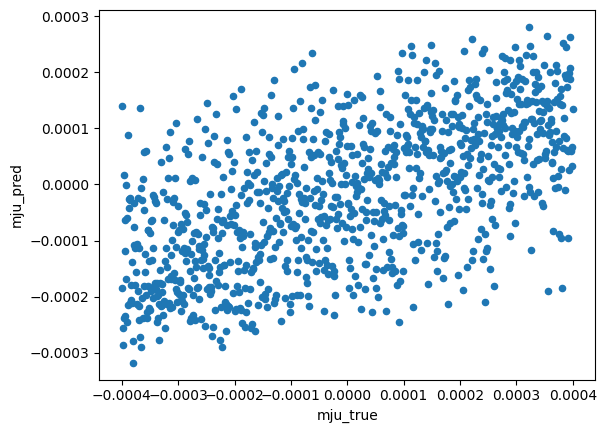

In [86]:
range_test_df.plot.scatter(x='mju_true', y='mju_pred')

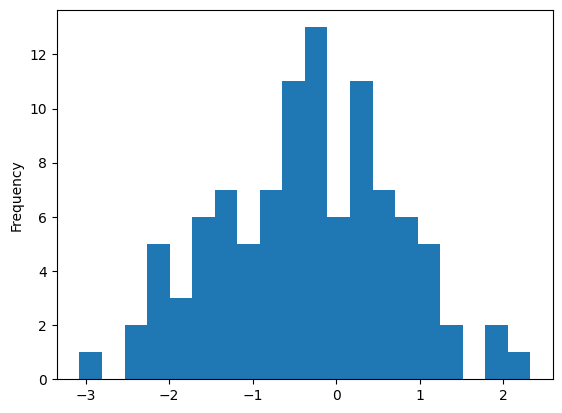

In [38]:
fixed_param_eval_df['mju_pred'].sub(fixed_param_eval_df['mju_true']).div(fixed_param_eval_df['mju_true']).plot.hist(bins=20)

In [18]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import r2_score
import logging

# Configure logging: write to file and console
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s',
                    filename='training.log',
                    filemode='w')
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)

# 1) SVJD simulation ----------------------------------------------------------
def simulate_svjd(mu, v_lt, beta, gamma, mu_j, sigma_j, lam, T, seed=None):
    """
    Simulate T returns from the SVJD model:
      h_t = alpha + beta * h_{t-1} + gamma * eps_h
      r_t = mu + exp(h_t/2) * eps_r + Z_t * J_t
    where
      alpha = ln(v_lt) * (1 - beta)
      eps_r, eps_h ~ N(0,1)
      Z_t ~ Bernoulli(lam)
      J_t ~ N(mu_j, sigma_j)
    """
    if seed is not None:
        np.random.seed(seed)
    alpha = np.log(v_lt) * (1 - beta)
    h = np.empty(T, dtype=np.float32)
    r = np.empty(T, dtype=np.float32)
    h[0] = alpha / (1 - beta)
    eps_h = np.random.randn(T).astype(np.float32)
    eps_r = np.random.randn(T).astype(np.float32)
    jumps = np.random.binomial(1, lam, size=T)
    J = mu_j + sigma_j * np.random.randn(T).astype(np.float32)
    for t in range(1, T):
        h[t] = alpha + beta * h[t-1] + gamma * eps_h[t]
    sigma = np.exp(h / 2)
    r = mu + sigma * eps_r + jumps * J
    return r

# 2) Dataset and normalization ------------------------------------------------
class SVJDDataset(Dataset):
    def __init__(self, returns, thetas, x_mean, x_std, y_mean, y_std):
        self.X = (returns - x_mean) / x_std
        self.Y = (thetas - y_mean) / y_std
        self.X = torch.from_numpy(self.X).unsqueeze(1).float()
        self.Y = torch.from_numpy(self.Y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 3) Causal conv + CNN model --------------------------------------------------
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.pad = nn.ConstantPad1d((kernel_size-1, 0), 0.0)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)

    def forward(self, x):
        return self.conv(self.pad(x))

class SVJD_CNN(nn.Module):
    def __init__(self, T, num_responses=7, num_filters=20, num_neurons=20, kernel_size=5, pool_size=5):
        super().__init__()
        # Conv block 1
        self.conv1 = nn.Sequential(
            CausalConv1d(1, num_filters, kernel_size),
            nn.LeakyReLU(),
            nn.LayerNorm([num_filters, T]),
            nn.AvgPool1d(kernel_size=pool_size, stride=1)
        )
        L1 = T - (pool_size - 1)
        # Conv block 2
        self.conv2 = nn.Sequential(
            CausalConv1d(num_filters, num_filters, kernel_size),
            nn.LeakyReLU(),
            nn.LayerNorm([num_filters, L1]),
            nn.AvgPool1d(kernel_size=pool_size, stride=pool_size)
        )
        L2 = (L1 - (pool_size - 1)) // pool_size
        # Conv block 3
        self.conv3 = nn.Sequential(
            CausalConv1d(num_filters, num_filters, kernel_size),
            nn.LeakyReLU(),
            nn.LayerNorm([num_filters, L2])
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        # Fully connected
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters, num_neurons),
            nn.LeakyReLU(),
            nn.LayerNorm(num_neurons),
            nn.Linear(num_neurons, num_neurons),
            nn.LeakyReLU(),
            nn.LayerNorm(num_neurons),
            nn.Linear(num_neurons, num_responses)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        return self.fc(x)

# 4) Training with early stopping ------------------------------------------------
def train_model(model, train_loader, val_loader, max_epochs=100, patience=50, lr=1e-3, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = np.inf
    epochs_no_improve = 0
    model.to(device)

    for epoch in range(1, max_epochs+1):
        model.train()
        train_loss_accum = 0.0
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            pred = model(Xb)
            loss = criterion(pred, Yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_accum += loss.item() * Xb.size(0)
        train_loss = train_loss_accum / len(train_loader.dataset)

        model.eval()
        val_loss_accum = 0.0
        with torch.no_grad():
            for Xv, Yv in val_loader:
                Xv, Yv = Xv.to(device), Yv.to(device)
                val_loss_accum += criterion(model(Xv), Yv).item() * Xv.size(0)
        val_loss = val_loss_accum / len(val_loader.dataset)

        logging.info(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_no_improve = 0
            logging.info(f"New best model saved at epoch {epoch} (Val Loss = {val_loss:.6f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                logging.info(f"Early stopping triggered at epoch {epoch}")
                break

    logging.info(f"Training complete. Best validation loss = {best_val:.6f}")
    model.load_state_dict(torch.load('best_model.pth'))
    return model

# 5) Main execution -------------------------------------------------------------
if __name__ == "__main__":
    logging.info("Starting SVJD CNN training")
    N_train, N_test = 500, 500
    T = 2000

    # Draw training parameters
    mus    = np.random.uniform(-0.1, 0.1, N_train).astype(np.float32) / 250
    v_lts  = np.random.uniform(0.005, 0.015, N_train).astype(np.float32)**2
    betas  = np.random.uniform(0.79, 0.99, N_train).astype(np.float32)
    gammas = np.random.uniform(0.05, 0.50, N_train).astype(np.float32)
    muj    = np.random.uniform(-0.05, 0.05, N_train).astype(np.float32)
    sigmaj = np.random.uniform(0.01, 0.10, N_train).astype(np.float32)
    lamb   = np.random.uniform(0.005, 0.05, N_train).astype(np.float32)

    logging.info("Simulating training returns...")
    R_train = np.vstack([
        simulate_svjd(mu, vlt, b, g, mj, sj, lm, T)
        for mu, vlt, b, g, mj, sj, lm in zip(mus, v_lts, betas, gammas, muj, sigmaj, lamb)
    ])
    Y_train = np.column_stack([mus, muj, sigmaj, v_lts, betas, gammas, lamb])

    # Normalization
    x_mean, x_std = R_train.mean(), R_train.std()
    y_mean, y_std = Y_train.mean(0), Y_train.std(0)

    dataset = SVJDDataset(R_train, Y_train, x_mean, x_std, y_mean, y_std)
    n_val = int(0.2 * len(dataset))
    train_ds, val_ds = random_split(dataset, [len(dataset)-n_val, n_val])
    train_loader = DataLoader(train_ds, batch_size=50, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=50)

    model = SVJD_CNN(T)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = train_model(model, train_loader, val_loader, device=device)

    # Evaluate on test set
    logging.info("Simulating test returns and evaluating model...")
    mus_t    = np.random.uniform(-0.1, 0.1, N_test).astype(np.float32) / 250
    v_lts_t  = np.random.uniform(0.005, 0.015, N_test).astype(np.float32)**2
    betas_t  = np.random.uniform(0.79, 0.99, N_test).astype(np.float32)
    gammas_t = np.random.uniform(0.05, 0.50, N_test).astype(np.float32)
    muj_t    = np.random.uniform(-0.05, 0.05, N_test).astype(np.float32)
    sigmaj_t = np.random.uniform(0.01, 0.10, N_test).astype(np.float32)
    lamb_t   = np.random.uniform(0.005, 0.05, N_test).astype(np.float32)

    R_test = np.vstack([
        simulate_svjd(mu, vlt, b, g, mj, sj, lm, T)
        for mu, vlt, b, g, mj, sj, lm in zip(mus_t, v_lts_t, betas_t, gammas_t, muj_t, sigmaj_t, lamb_t)
    ])
    Y_test = np.column_stack([mus_t, muj_t, sigmaj_t, v_lts_t, betas_t, gammas_t, lamb_t])

    # Normalize and predict
    X_test = torch.from_numpy((R_test - x_mean) / x_std).unsqueeze(1).to(device)
    model.eval()
    with torch.no_grad():
        Y_pred_norm = model(X_test).cpu().numpy()
    Y_pred = Y_pred_norm * y_std[None, :] + y_mean[None, :]

    # Log R^2 for each parameter
    for i, name in enumerate(["mu","muJ","sigmaJ","vLT","beta","gamma","lambda"]):
        score = r2_score(Y_test[:,i], Y_pred[:,i])
        logging.info(f"Test R^2 for {name}: {score:.4f}")

    logging.info("Evaluation complete.")


2025-05-20 22:23:39,323 INFO Starting SVJD CNN training
2025-05-20 22:23:39,323 INFO Starting SVJD CNN training
2025-05-20 22:23:39,323 INFO Starting SVJD CNN training
2025-05-20 22:23:39,323 INFO Starting SVJD CNN training
2025-05-20 22:23:39,323 INFO Starting SVJD CNN training
2025-05-20 22:23:39,324 INFO Simulating training returns...
2025-05-20 22:23:39,324 INFO Simulating training returns...
2025-05-20 22:23:39,324 INFO Simulating training returns...
2025-05-20 22:23:39,324 INFO Simulating training returns...
2025-05-20 22:23:39,324 INFO Simulating training returns...


RuntimeError: Given normalized_shape=[20, 398], expected input with shape [*, 20, 398], but got input of size[50, 20, 399]

# Transformer based

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import math
import os
import time
from tqdm import tqdm

# Configuration
CONFIG = {
    "T": 24*90,  # Length of return series (2160)
    "N_TRAIN": 100_000,
    "N_VAL": 5000,
    "N_TEST": 1000,
    "PARAM_NAMES": ['mu', 'v_LT', 'beta', 'gamma', 'mu_J', 'sigma_J', 'lambda_J'],
    "MODEL_PARAMS": {
        # CNN Stem parameters
        "cnn_out_channels": [64, 128], # Channels for CNN layers
        "cnn_kernel_sizes": [7, 5],    # Kernel sizes for CNN layers
        "cnn_strides": [1, 1],         # Strides for CNN layers (conv)
        "cnn_padding": [3, 2],         # Padding for CNN layers (conv)
        "cnn_pool_kernel_sizes": [2, 2], # MaxPool kernel size after each CNN layer
        "cnn_pool_strides": [2, 2],     # MaxPool stride after each CNN layer

        # Transformer parameters
        # d_model should match the last cnn_out_channels if cnn_final_proj is False
        # Or, cnn_out_channels[-1] will be projected to d_model
        "d_model": 256,                 # Embedding dimension for Transformer
        "nhead": 8,                     # Number of attention heads
        "num_encoder_layers": 6,        # Number of Transformer encoder layers
        "dim_feedforward": 1024,        # Dimension of feedforward network (e.g., 4 * d_model)
        "dropout": 0.15,                # Dropout rate in Transformer
    },
    "TRAINING_PARAMS": {
        "batch_size": 128, # Adjusted for potentially larger model
        "learning_rate": 1e-4, # Base LR
        "epochs": 100,
        "early_stopping_patience": 15, # Increased patience
        "warmup_epochs": 5, # Number of epochs for LR warmup
    },
    "SEED": 42,
    "TENSORBOARD_LOG_DIR": "runs/svj_transformer_v3_conv_cls_lrwarmup_cap",
    "MODEL_SAVE_PATH": "best_svj_transformer_v3.pth",
}

# Set seed for reproducibility
np.random.seed(CONFIG["SEED"])
torch.manual_seed(CONFIG["SEED"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["SEED"])

# --- 1. SVJ Model Simulation (Vectorized -UNCHANGED from previous version) ---
def generate_svj_parameters_vectorized(num_samples, param_names_list):
    params_dict = {}
    params_dict['mu'] = np.random.uniform(-0.1, 0.1, size=num_samples) / 250.0
    params_dict['v_LT'] = np.random.uniform(0.005, 0.015, size=num_samples)**2
    params_dict['beta'] = np.random.uniform(0.79, 0.99, size=num_samples)
    params_dict['gamma'] = np.random.uniform(0.05, 0.50, size=num_samples)
    params_dict['mu_J'] = np.random.uniform(-0.05, 0.05, size=num_samples)
    sigma_J_raw = np.random.uniform(0.01, 0.10, size=num_samples)
    params_dict['sigma_J'] = np.maximum(sigma_J_raw, 1e-6)
    params_dict['lambda_J'] = np.random.uniform(0.005, 0.05, size=num_samples)
    Y = np.stack([params_dict[name] for name in param_names_list], axis=1)
    return Y

def simulate_svj_series_vectorized(params_array, T, param_names_list):
    num_samples = params_array.shape[0]
    params_dict = {name: params_array[:, i] for i, name in enumerate(param_names_list)}
    mu, v_LT, beta, gamma, mu_J, sigma_J, lambda_J = (
        params_dict['mu'], params_dict['v_LT'], params_dict['beta'], params_dict['gamma'],
        params_dict['mu_J'], params_dict['sigma_J'], params_dict['lambda_J']
    )
    v_LT_safe = np.maximum(v_LT, 1e-8)
    alpha = np.log(v_LT_safe) * (1 - beta)
    returns = np.zeros((num_samples, T))
    log_variances = np.zeros((num_samples, T))
    log_variances[:, 0] = np.log(v_LT_safe)
    for t in tqdm(range(T), desc="Simulating time steps", leave=False):
        if t > 0:
            eps_h = np.random.normal(0, 1, size=num_samples)
            log_variances[:, t] = alpha + beta * log_variances[:, t-1] + gamma * eps_h
        else:
            log_variances[:, t] = log_variances[:, 0]
        sigma_t_sq = np.exp(log_variances[:, t])
        sigma_t_sq_safe = np.maximum(sigma_t_sq, 1e-10)
        sigma_t = np.sqrt(sigma_t_sq_safe)
        Z_t = np.random.binomial(1, lambda_J)
        J_t = np.zeros(num_samples)
        jump_indices = Z_t > 0
        num_active_jumps = np.sum(jump_indices)
        if num_active_jumps > 0:
            J_t[jump_indices] = np.random.normal(mu_J[jump_indices], sigma_J[jump_indices], size=num_active_jumps)
        eps_r = np.random.normal(0, 1, size=num_samples)
        returns[:, t] = mu + sigma_t * eps_r + J_t
    return returns

def generate_dataset_vectorized(num_samples, T, param_names_list):
    print(f"Generating {num_samples} parameter sets (vectorized)...")
    Y_params = generate_svj_parameters_vectorized(num_samples, param_names_list)
    print(f"Simulating {num_samples} series (vectorized across samples, iterative over T)...")
    X_returns = simulate_svj_series_vectorized(Y_params, T, param_names_list)
    return torch.tensor(X_returns, dtype=torch.float32), torch.tensor(Y_params, dtype=torch.float32)

# --- 2. Dataset and Normalization (UNCHANGED) ---
class SVJDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

def normalize_params(params_tensor, means=None, stds=None):
    if means is None or stds is None:
        means = params_tensor.mean(dim=0, keepdim=True)
        stds = params_tensor.std(dim=0, keepdim=True)
        stds[stds == 0] = 1
    return (params_tensor - means) / stds, means, stds

def denormalize_params(normalized_params_tensor, means, stds):
    return normalized_params_tensor * stds + means

def normalize_returns(returns_tensor, mean=None, std=None):
    if mean is None or std is None:
        mean = returns_tensor.mean()
        std = returns_tensor.std()
        if std == 0: std = 1
    return (returns_tensor - mean) / std, mean, std

# --- 3. Transformer Model (MODIFIED) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): # max_len should be dynamic or large enough
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x): # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class SVJTransformer(nn.Module):
    def __init__(self, num_params_to_predict, T_input, model_config):
        super(SVJTransformer, self).__init__()
        
        self.d_model = model_config["d_model"]
        
        # Convolutional Stem
        cnn_layers = []
        current_channels = 1 # Input is univariate time series
        current_T = T_input
        
        cnn_out_channels_list = model_config["cnn_out_channels"]
        cnn_kernel_sizes_list = model_config["cnn_kernel_sizes"]
        cnn_strides_list = model_config["cnn_strides"]
        cnn_padding_list = model_config["cnn_padding"]
        cnn_pool_kernel_sizes_list = model_config["cnn_pool_kernel_sizes"]
        cnn_pool_strides_list = model_config["cnn_pool_strides"]

        for i in range(len(cnn_out_channels_list)):
            cnn_layers.append(nn.Conv1d(
                in_channels=current_channels,
                out_channels=cnn_out_channels_list[i],
                kernel_size=cnn_kernel_sizes_list[i],
                stride=cnn_strides_list[i],
                padding=cnn_padding_list[i]
            ))
            cnn_layers.append(nn.ReLU())
            # Optional: BatchNorm1d
            # cnn_layers.append(nn.BatchNorm1d(cnn_out_channels_list[i]))
            cnn_layers.append(nn.MaxPool1d(
                kernel_size=cnn_pool_kernel_sizes_list[i],
                stride=cnn_pool_strides_list[i]
            ))
            current_channels = cnn_out_channels_list[i]
            # Calculate T after conv
            current_T = math.floor((current_T + 2 * cnn_padding_list[i] - (cnn_kernel_sizes_list[i]-1) - 1) / cnn_strides_list[i] + 1)
            # Calculate T after pool
            current_T = math.floor((current_T - (cnn_pool_kernel_sizes_list[i]-1) -1) / cnn_pool_strides_list[i] + 1)

        self.cnn_stem = nn.Sequential(*cnn_layers)
        self.cnn_output_seq_len = current_T
        
        # Projection if CNN output channels don't match d_model for Transformer
        if current_channels != self.d_model:
            self.cnn_to_transformer_proj = nn.Linear(current_channels, self.d_model)
        else:
            self.cnn_to_transformer_proj = nn.Identity()

        # CLS Token
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.d_model)) # Learnable parameter

        # Positional Encoding (max_len needs to be cnn_output_seq_len + 1 for CLS)
        self.pos_encoder = PositionalEncoding(self.d_model, model_config["dropout"], max_len=self.cnn_output_seq_len + 1)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            self.d_model, model_config["nhead"], model_config["dim_feedforward"],
            model_config["dropout"], batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, model_config["num_encoder_layers"])
        
        # Regression head
        self.fc_head = nn.Sequential(
            nn.Linear(self.d_model, self.d_model // 2),
            nn.ReLU(),
            nn.Dropout(model_config["dropout"]), # Add dropout in head too
            nn.Linear(self.d_model // 2, num_params_to_predict)
        )

    def forward(self, src):
        # src shape: (batch_size, seq_len)
        src = src.unsqueeze(1) # (batch_size, 1, seq_len) for Conv1d
        
        # Pass through CNN stem
        x = self.cnn_stem(src) # (batch_size, cnn_out_channels[-1], cnn_output_seq_len)
        x = x.permute(0, 2, 1) # (batch_size, cnn_output_seq_len, cnn_out_channels[-1])
        
        # Project to d_model if necessary
        x = self.cnn_to_transformer_proj(x) # (batch_size, cnn_output_seq_len, d_model)

        # Prepend CLS token
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1) # (batch_size, 1, d_model)
        x = torch.cat((cls_tokens, x), dim=1) # (batch_size, cnn_output_seq_len + 1, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Pass through Transformer encoder
        output = self.transformer_encoder(x) # (batch_size, cnn_output_seq_len + 1, d_model)
        
        # Use the output of the CLS token for prediction
        cls_output = output[:, 0, :] # (batch_size, d_model)
        
        predictions = self.fc_head(cls_output) # (batch_size, num_params_to_predict)
        return predictions

# --- 4. Utility Functions (UNCHANGED) ---
def r_squared(y_true, y_pred, per_param=True):
    if not isinstance(y_true, torch.Tensor): y_true = torch.tensor(y_true)
    if not isinstance(y_pred, torch.Tensor): y_pred = torch.tensor(y_pred)
    if per_param:
        r2_scores = []
        for i in range(y_true.shape[1]):
            ss_res = torch.sum((y_true[:, i] - y_pred[:, i])**2)
            ss_tot = torch.sum((y_true[:, i] - torch.mean(y_true[:, i]))**2)
            if ss_tot == 0: r2 = 1.0 if ss_res < 1e-9 else 0.0
            else: r2 = 1 - ss_res / ss_tot
            r2_scores.append(r2.item())
        return r2_scores
    else:
        ss_res = torch.sum((y_true - y_pred)**2)
        ss_tot = torch.sum((y_true - torch.mean(y_true))**2)
        if ss_tot == 0: return 1.0 if ss_res < 1e-9 else 0.0
        return (1 - ss_res / ss_tot).item()

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, checkpoint_path="best_model.pth"):
        self.patience = patience; self.min_delta = min_delta; self.checkpoint_path = checkpoint_path
        self.counter = 0; self.best_loss = float('inf'); self.early_stop = False
    def __call__(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss; self.counter = 0
            torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.counter += 1
            if self.counter >= self.patience: print("Early stopping triggered."); self.early_stop = True
        return self.early_stop

# --- 5. Training and Evaluation Loop (MODIFIED for LR Warmup) ---
def train_model(model, train_loader, optimizer, criterion, device, param_means, param_stds, epoch, train_config):
    model.train()
    total_loss = 0
    
    # LR Warmup
    base_lr = train_config["learning_rate"]
    warmup_epochs = train_config["warmup_epochs"]
    if epoch <= warmup_epochs:
        # Linear warmup: lr = base_lr * (current_epoch / warmup_epochs)
        # Ensure epoch is 1-indexed for this formula
        lr = base_lr * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epoch == warmup_epochs + 1 : # After warmup, set to base_lr (if no other scheduler)
         for param_group in optimizer.param_groups:
            param_group['lr'] = base_lr
    current_lr = optimizer.param_groups[0]['lr']


    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch} (LR: {current_lr:.2e})")
    for batch_idx, (data, target_params_orig) in enumerate(pbar):
        data = data.to(device)
        target_params_orig = target_params_orig.to(device)
        target_params_norm = (target_params_orig - param_means.to(device)) / param_stds.to(device)
        optimizer.zero_grad()
        predictions_norm = model(data)
        loss = criterion(predictions_norm, target_params_norm)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 50 == 0:
             pbar.set_postfix({"Loss": loss.item()})
    avg_loss = total_loss / len(train_loader)
    return avg_loss, current_lr


def evaluate_model(model, data_loader, criterion, device, param_names_list, param_means, param_stds, is_test_set=False):
    model.eval()
    total_loss = 0
    all_predictions_denorm, all_targets_denorm = [], []
    desc = "Testing" if is_test_set else "Evaluating"
    with torch.no_grad():
        for data, target_params_orig in tqdm(data_loader, desc=desc, leave=False):
            data, target_params_orig = data.to(device), target_params_orig.to(device)
            target_params_norm = (target_params_orig - param_means.to(device)) / param_stds.to(device)
            predictions_norm = model(data)
            loss = criterion(predictions_norm, target_params_norm)
            total_loss += loss.item()
            predictions_denorm = denormalize_params(predictions_norm, param_means.to(device), param_stds.to(device))
            all_predictions_denorm.append(predictions_denorm.cpu())
            all_targets_denorm.append(target_params_orig.cpu())
    avg_loss = total_loss / len(data_loader)
    all_predictions_denorm = torch.cat(all_predictions_denorm, dim=0)
    all_targets_denorm = torch.cat(all_targets_denorm, dim=0)
    r2_scores_per_param = r_squared(all_targets_denorm, all_predictions_denorm, per_param=True)
    print_prefix = "Test" if is_test_set else "Validation"
    print(f"\n--- {print_prefix} Results ---")
    print(f"{print_prefix} Loss (norm): {avg_loss:.6f}")
    for i, name in enumerate(param_names_list): print(f"{print_prefix} R² for {name} (denorm): {r2_scores_per_param[i]:.4f}")
    print("-------------------------\n")
    return avg_loss, r2_scores_per_param

# --- 6. Parameter Sweep Function (UNCHANGED) ---
def perform_parameter_sweep(model, fixed_params_base, param_to_sweep_idx, sweep_values,
                            T, n_series_per_value, device,
                            return_norm_mean, return_norm_std, 
                            param_norm_means, param_norm_stds, 
                            param_names_list):
    model.eval()
    results_pred = {name: [] for name in param_names_list}
    true_swept_values_recorded = []
    print(f"\n--- Performing Parameter Sweep for {param_names_list[param_to_sweep_idx]} ---")
    for sweep_val in tqdm(sweep_values, desc=f"Sweeping {param_names_list[param_to_sweep_idx]}", leave=False):
        current_params_true_denorm = np.copy(fixed_params_base)
        current_params_true_denorm[param_to_sweep_idx] = sweep_val
        true_swept_values_recorded.append(sweep_val)
        batch_returns_list_for_sweep = []
        for _ in range(n_series_per_value):
            series_single = simulate_svj_series_vectorized(current_params_true_denorm.reshape(1, -1), T, param_names_list)
            batch_returns_list_for_sweep.append(torch.tensor(series_single, dtype=torch.float32))
        batch_returns_for_sweep = torch.cat(batch_returns_list_for_sweep, dim=0)
        batch_returns_norm, _, _ = normalize_returns(batch_returns_for_sweep, return_norm_mean, return_norm_std)
        batch_returns_norm = batch_returns_norm.to(device)
        with torch.no_grad():
            predictions_norm = model(batch_returns_norm)
            predictions_denorm = denormalize_params(predictions_norm, param_norm_means.to(device), param_norm_stds.to(device))
            avg_predictions_denorm = predictions_denorm.mean(dim=0).cpu().numpy()
        for i, name in enumerate(param_names_list): results_pred[name].append(avg_predictions_denorm[i])
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 7)); param_name_swept = param_names_list[param_to_sweep_idx]
    plt.plot(true_swept_values_recorded, results_pred[param_name_swept], 'o-', label=f'Avg. Predicted {param_name_swept}')
    plt.plot(true_swept_values_recorded, true_swept_values_recorded, 'k--', label='True Value (Ideal)')
    plt.xlabel(f'True {param_name_swept}'); plt.ylabel(f'Predicted {param_name_swept}')
    plt.title(f'Parameter Sweep Analysis: {param_name_swept}'); plt.legend(); plt.grid(True)
    sweep_plot_filename = f"sweep_{param_name_swept}.png"; plt.savefig(sweep_plot_filename)
    print(f"Parameter sweep plot saved to {sweep_plot_filename}"); plt.close()
    return results_pred, true_swept_values_recorded

# --- Main Execution ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    X_train_raw, Y_train_raw = generate_dataset_vectorized(CONFIG["N_TRAIN"], CONFIG["T"], CONFIG["PARAM_NAMES"])
    X_val_raw, Y_val_raw = generate_dataset_vectorized(CONFIG["N_VAL"], CONFIG["T"], CONFIG["PARAM_NAMES"])
    X_test_raw, Y_test_raw = generate_dataset_vectorized(CONFIG["N_TEST"], CONFIG["T"], CONFIG["PARAM_NAMES"])

    X_train_norm, return_mean_norm, return_std_norm = normalize_returns(X_train_raw)
    X_val_norm, _, _ = normalize_returns(X_val_raw, return_mean_norm, return_std_norm)
    X_test_norm, _, _ = normalize_returns(X_test_raw, return_mean_norm, return_std_norm)
    _, param_means_norm, param_stds_norm = normalize_params(Y_train_raw)

    train_dataset = SVJDataset(X_train_norm, Y_train_raw)
    val_dataset = SVJDataset(X_val_norm, Y_val_raw)
    test_dataset = SVJDataset(X_test_norm, Y_test_raw)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["TRAINING_PARAMS"]["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["TRAINING_PARAMS"]["batch_size"], shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["TRAINING_PARAMS"]["batch_size"], shuffle=False, num_workers=4, pin_memory=True)
    
    model = SVJTransformer(
        num_params_to_predict=len(CONFIG["PARAM_NAMES"]),
        T_input=CONFIG["T"],
        model_config=CONFIG["MODEL_PARAMS"]
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["TRAINING_PARAMS"]["learning_rate"], weight_decay=1e-4) # AdamW is often better
    criterion = nn.MSELoss()
    early_stopper = EarlyStopping(patience=CONFIG["TRAINING_PARAMS"]["early_stopping_patience"], checkpoint_path=CONFIG["MODEL_SAVE_PATH"])
    writer = SummaryWriter(CONFIG["TENSORBOARD_LOG_DIR"])
    print(f"Model outputting to {CONFIG['TENSORBOARD_LOG_DIR']} and {CONFIG['MODEL_SAVE_PATH']}")
    print(f"Model initialized. CNN output seq len: {model.cnn_output_seq_len}, Positional encoding max_len: {model.pos_encoder.pe.size(1)}")
    print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    print("\n--- Starting Training ---")
    for epoch in range(1, CONFIG["TRAINING_PARAMS"]["epochs"] + 1):
        start_time = time.time()
        train_loss, current_lr = train_model(model, train_loader, optimizer, criterion, device, param_means_norm, param_stds_norm, epoch, CONFIG["TRAINING_PARAMS"])
        val_loss, val_r2_scores = evaluate_model(model, val_loader, criterion, device, CONFIG["PARAM_NAMES"], param_means_norm, param_stds_norm)
        end_time = time.time()
        print(f"Epoch {epoch}/{CONFIG['TRAINING_PARAMS']['epochs']} - Time: {end_time-start_time:.2f}s - LR: {current_lr:.2e} - Train Loss (norm): {train_loss:.6f} - Val Loss (norm): {val_loss:.6f}")
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Learning_Rate', current_lr, epoch)
        for i, name in enumerate(CONFIG["PARAM_NAMES"]): writer.add_scalar(f'R2_Validation/{name}', val_r2_scores[i], epoch)
        if early_stopper(val_loss, model): break
    
    writer.close()
    print("--- Training Finished ---")

    print("\n--- Evaluating on Test Set with Best Model ---")
    if os.path.exists(CONFIG["MODEL_SAVE_PATH"]):
        model.load_state_dict(torch.load(CONFIG["MODEL_SAVE_PATH"]))
        test_loss, test_r2_scores = evaluate_model(model, test_loader, criterion, device, CONFIG["PARAM_NAMES"], param_means_norm, param_stds_norm, is_test_set=True)
    else:
        print(f"Warning: Model checkpoint {CONFIG['MODEL_SAVE_PATH']} not found. Skipping test set evaluation with best model.")


    print("\n--- Starting Parameter Sweep Example ---")
    if os.path.exists(CONFIG["MODEL_SAVE_PATH"]):
        fixed_params_base_for_sweep = Y_train_raw.mean(dim=0).numpy()
        param_to_sweep = 'beta'; param_to_sweep_idx = CONFIG["PARAM_NAMES"].index(param_to_sweep)
        beta_sim_range = (0.79, 0.99); beta_sweep_values = np.linspace(beta_sim_range[0], beta_sim_range[1], 10)
        perform_parameter_sweep(model, fixed_params_base_for_sweep, param_to_sweep_idx, beta_sweep_values,
                                CONFIG["T"], 20, device, return_mean_norm, return_std_norm,
                                param_means_norm, param_stds_norm, CONFIG["PARAM_NAMES"])
    else:
        print(f"Warning: Model checkpoint {CONFIG['MODEL_SAVE_PATH']} not found. Skipping parameter sweep.")
    print("--- Script Finished ---")


Using device: cuda
Generating 100000 parameter sets (vectorized)...
Simulating 100000 series (vectorized across samples, iterative over T)...


Generating 5000 parameter sets (vectorized)...
Simulating 5000 series (vectorized across samples, iterative over T)...


Generating 1000 parameter sets (vectorized)...
Simulating 1000 series (vectorized across samples, iterative over T)...


Model outputting to runs/svj_transformer_v3_conv_cls_lrwarmup_cap and best_svj_transformer_v3.pth
Model initialized. CNN output seq len: 540, Positional encoding max_len: 541
Total trainable parameters: 4,847,239

--- Starting Training ---


Training Epoch 1 (LR: 2.00e-05): 100%|██████████| 782/782 [05:47<00:00,  2.25it/s, Loss=0.595]



--- Validation Results ---
Validation Loss (norm): 0.566122
Validation R² for mu (denorm): 0.0362
Validation R² for v_LT (denorm): 0.8587
Validation R² for beta (denorm): 0.2175
Validation R² for gamma (denorm): 0.2148
Validation R² for mu_J (denorm): 0.7512
Validation R² for sigma_J (denorm): 0.6281
Validation R² for lambda_J (denorm): 0.3225
-------------------------

Epoch 1/100 - Time: 352.45s - LR: 2.00e-05 - Train Loss (norm): 0.726170 - Val Loss (norm): 0.566122


Training Epoch 2 (LR: 4.00e-05): 100%|██████████| 782/782 [05:58<00:00,  2.18it/s, Loss=0.412]



--- Validation Results ---
Validation Loss (norm): 0.469295
Validation R² for mu (denorm): 0.0456
Validation R² for v_LT (denorm): 0.9058
Validation R² for beta (denorm): 0.3033
Validation R² for gamma (denorm): 0.3323
Validation R² for mu_J (denorm): 0.8115
Validation R² for sigma_J (denorm): 0.8095
Validation R² for lambda_J (denorm): 0.5045
-------------------------

Epoch 2/100 - Time: 363.01s - LR: 4.00e-05 - Train Loss (norm): 0.483592 - Val Loss (norm): 0.469295


Training Epoch 3 (LR: 6.00e-05): 100%|██████████| 782/782 [05:56<00:00,  2.19it/s, Loss=0.364]



--- Validation Results ---
Validation Loss (norm): 0.325416
Validation R² for mu (denorm): 0.4838
Validation R² for v_LT (denorm): 0.9312
Validation R² for beta (denorm): 0.3708
Validation R² for gamma (denorm): 0.5769
Validation R² for mu_J (denorm): 0.8419
Validation R² for sigma_J (denorm): 0.8724
Validation R² for lambda_J (denorm): 0.6321
-------------------------

Epoch 3/100 - Time: 361.74s - LR: 6.00e-05 - Train Loss (norm): 0.386017 - Val Loss (norm): 0.325416


Training Epoch 4 (LR: 8.00e-05):  34%|███▍      | 265/782 [02:00<04:10,  2.06it/s, Loss=0.371]